## Imports & preparation

In [340]:
import scipy
import paths
from utils import *
import pickle
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

# Import the Generator class
from bioverse.generator import Generator
from bioverse.survey import TransitSurvey
from bioverse.constants import CONST, DATA_DIR
# from bioverse import util
from bioverse import plots


# Import pyplot (for making plots later) and adjust some of its settings
from matplotlib import pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

# %matplotlib osx
# %matplotlib inline

import plotstyle
plotstyle.styleplots()


%load_ext autoreload
%autoreload 2

pd.options.display.max_rows = 100
pd.options.display.max_columns = 80

figdir = '/Users/schlecker/repos/magmaocean/src/tex/figures/'
talkfigdir = '/Users/schlecker/talks/20221107_HabitableWorlds_Bioverse/figures/' 
paperdatadir = '/Users/schlecker/repos/magmaocean/src/data/'
papertexdir = '/Users/schlecker/repos/magmaocean/src/tex/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## preparatory steps (to be done only once)

Read in Dorn & Lichtenberg 2021 Fig. 3b from plot line extractor

Text(0, 0.5, 'Radius deviation')

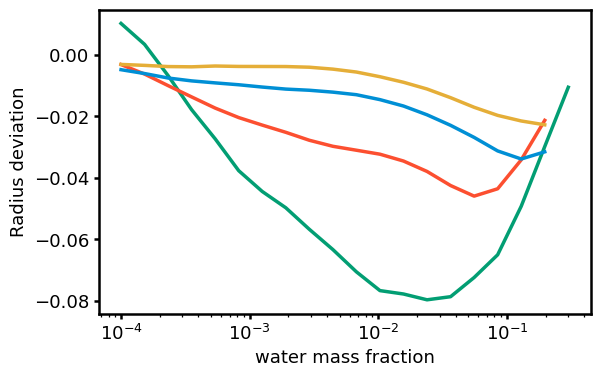

In [2]:
from scipy.interpolate import interp1d
from bioverse.constants import DATA_DIR

wrr_grid = np.geomspace(1e-4, 3e-1, num=20)
xy = {'wrr' : wrr_grid}

for i, (mp, mp_flt) in enumerate(zip(['0p3', '0p8', '2p4', '6p7'], [0.3, 0.8, 2.4, 6.7])):
    # read extracted csv file (from plot extraction tool)
    df = pd.read_csv(DATA_DIR + 'deltaR_DornLichtenberg21_Fig3b_extracted.csv', usecols=[2*i,2*i+1])
    f_xy = interp1d(df[mp + 'x'], df[mp + 'y'], fill_value='extrapolate')
    xy[mp_flt] = f_xy(wrr_grid)
    
    plt.plot(xy['wrr'], xy[mp_flt])
plt.xscale('log')
plt.xlabel('water mass fraction')
plt.ylabel('Radius deviation')

# # pd.DataFrame(xy).to_csv(DATA_DIR + 'deltaR_DornLichtenberg21_Fig3b.csv', index=False)

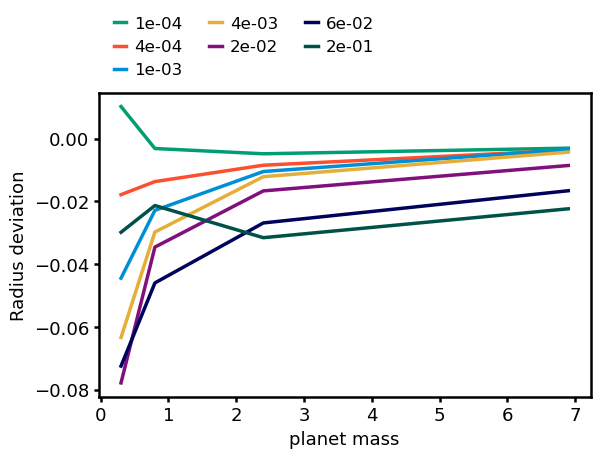

In [3]:
# sanity-check the interpolation
df = pd.read_csv(DATA_DIR + 'deltaR_DornLichtenberg21_Fig3b.csv', )

mass_grid = np.arange(0.3, 7., 0.1)

for wrr in wrr_grid[::3]:
    dr_wrr = df.iloc[(df['wrr'] - wrr).abs().argsort()[0], :][1:]
    f_dr = interp1d(dr_wrr.index.to_numpy(dtype=float), dr_wrr.values, fill_value='extrapolate')
    dr = f_dr(mass_grid)
    plt.plot(mass_grid, dr, label = '{:.0e}'.format(wrr))

# for i, mp_flt in enumerate([0.3, 0.8, 2.4, 6.7]):
    # f_xy = interp1d(df[mp + 'x'], df[mp + 'y'], fill_value='extrapolate')
    # xy[mp_flt] = f_xy(wrr_grid)
    # plt.plot(df['wrr'], df[str(mp_flt)])
    
# plt.xscale('log')

plt.xlabel('planet mass')
plt.ylabel('Radius deviation')
plt.legend(fontsize=12, loc='lower left', ncol=3, bbox_to_anchor=(0.0, 1.),
                              frameon=False, columnspacing=1.6)
 

# Sample generation

## Generate stars and planets, inject magma oceans


Keep only small planets/low-mass planets, but above 0.1 M_Earth (Turbet+2020 covers only 0.1 to 2 Mearth). Don't consider "lava worlds" with extremely high instellation.

Set a generic detection bias: transit depth $\delta > 75$ ppm.

In [690]:
# Parameters of the analysis
# parameter_of_interest = 'rho'
parameter_of_interest = 'R'

def get_generator_args():
    """ define generator parameters"""
    # Parameters for star generation 
    stars_args = {
    # 'd_max' : 90,             # max. dist to stars (pc) ~~(nominal=90, ca. 481 planets)~~
    'd_max' : 74,             
    'M_st_max' : 1.5,         # Maximum stellar mass to consider, in solar units.
    # 'M_G_max' : 11,           # Maximum gaia magnitude of stars
    'M_G_max' : 16,           # Maximum gaia magnitude of stars
        
    'seed' : 42,              # seed for random number generators
    'lum_evo' : True          # luminosities from luminosity tracks (Baraffe et al. 1998), based on random ages? [SLOW?]
    } 

    # Parameters for planet generation and magma ocean model
    planets_args = {
    'transit_mode': True,      # Simulate only transiting planets
    'f_eta' : 1.,               # Occurrence rate scaling factor
    'R_min' : 0.75,             # minimum radius for Bergsten et al. planet generator
    'P_max' : 500.,             # maximum period for Bergsten et al. planet generator

    'mr_relation' : 'Zeng2016', # choice of mass-radius relationship ('Zeng2016'/'Wolfgang2016/'earthlike')
    # 'mr_relation' : 'Wolfgang2016', 
    # 'mr_relation' : 'earthlike',

    'gh_increase' : True,       # wether or not to consider radius increase due to runaway greenhouse effect (Turbet+2020)
    'water_incorp' : True,      # wether or not to consider water incorporation in the melt of global magma oceans (Dorn & Lichtenberg 2021)
    'S_thresh' : 280.,          # threshold instellation for runaway greenhouse phase
    'wrr' : 0.005,              # water-to-rock ratio for Turbet+2020 model. Possible vals: 0.0001,0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05
    'f_rgh' : .8,               # fraction of planets with a runaway gh climate _within_ the runaway gh regime 
        
    'simplified' : False,       # increase the radii of all runaway greenhouse planets by the same fraction
    # 'diff_frac' : 0.48,       # fractional radius change in the simplified case.

    # detection bias and sample selection: Keep only small planets/low-mass planets, but above 0.1 M_Earth (Turbet+2020 covers only 0.1 to 2 Mearth). Don't consider "lava worlds" with extremely high instellation.
    # Set a generic detection bias: transit depth $\delta > 75$ ppm.
    'M_min' : 0.1,
    'M_max' : 2.,
    'S_min' : 10.,              # min. instellation in W/m2
    'S_max' : 2000.,            # max. instellation in W/m2
    'depth_min' : 80e-6         # min. transit depth
        
    # 'window' : 25               # window size of the rolling mean of radius/density
    }
    return stars_args, planets_args

def generate_generator(stars_only=False, **kwargs):
    stars_args, planets_args = get_generator_args()
    g_args = stars_args | planets_args  
    for key, value in kwargs.items():
        g_args[key] = value
    g_transit = Generator(label=None)
    g_transit.insert_step('read_stars_Gaia') 
    if not stars_only:
        g_transit.insert_step('create_planets_bergsten')
        g_transit.insert_step('assign_orbital_elements')
        g_transit.insert_step('impact_parameter')
        g_transit.insert_step('assign_mass')
        g_transit.insert_step('effective_values')
        g_transit.insert_step('magma_ocean')     # here we inject the magma oceans
        g_transit.insert_step('compute_transit_params')
        g_transit.insert_step('apply_bias')
    [g_transit.set_arg(key, val) for key, val in g_args.items()]
    return g_transit
    

In [691]:
%%time
# Create the first generator manually so we have stars and planets separated    
g_transit = Generator(label=None)
g_transit.insert_step('read_stars_Gaia') 
stars_args, planets_args = get_generator_args()
# # provide generator arguments chosen above
[g_transit.set_arg(key, val) for key, val in stars_args.items()]

# # Insert a function to the generator that labels late M dwarfs, defining a stellar mass threshold Mst_threshold.
# # g_transit.insert_step(label_lateM)

# # the stellar sample alone can be extracted here:
stars = g_transit.generate() 
# # stars.to_pandas().M_st.hist()
# # plt.xlabel('M_star')

# # Generate planets
g_transit.insert_step('create_planets_bergsten')
g_transit.insert_step('assign_orbital_elements')
g_transit.insert_step('impact_parameter')
g_transit.insert_step('assign_mass')
g_transit.insert_step('effective_values')
g_transit.insert_step('magma_ocean')     # here we inject the magma oceans
g_transit.insert_step('compute_transit_params')
g_transit.insert_step('apply_bias')

# # provide generator arguments chosen above
[g_transit.set_arg(key, val) for key, val in planets_args.items()]

# # save the generator
# # g_transit.save('transit_magmaocean')

# # show generator steps
# g_transit

sample = g_transit.generate()
print('Total number of planets: {}'.format(len(sample)))

Created a new Generator
Total number of planets: 497
CPU times: user 2min 34s, sys: 2.06 s, total: 2min 36s
Wall time: 2min 38s


# Most general results, model tests

## Test Bergsten et al. occurrence rates implementation

In [692]:
# # show sample in period-radius:
# yvar = parameter_of_interest

# sampledf = sample.to_pandas()
# early = sampledf[sampledf.M_st > 0.9].sample(100)
# late = sampledf[sampledf.M_st < 0.2].sample(30)

# fig, ax = plt.subplots(figsize=[10, 6])
# for sampledf, label in zip([early, late], ['early', 'late']):

#     ax.scatter(sampledf[sampledf.transiting==False].a_eff, sampledf[sampledf.transiting==False][yvar], s=5., alpha=.7, label=label)

#     # transiting planets
#     # ax.scatter(sampledf[sampledf.transiting==True].a_eff, sampledf[sampledf.transiting==True][yvar], s=20,  marker='x', c='C1', label='transiting')

#     # show differences in radius due to magma ocean
#     if yvar =='R':
#         X_coords= np.array([sampledf[sampledf.transiting==True].a_eff, sampledf[sampledf.transiting==True].a_eff])
#         Y_coords=np.array([sampledf[sampledf.transiting==True].R_orig, sampledf[sampledf.transiting==True].R])
#         ax.plot(X_coords, Y_coords, c='k', lw=1., alpha=.4, zorder=-1)

#         ax.set_ylabel('Radius [$R_\oplus$]')
#     elif yvar == 'rho':
#         ax.set_ylabel('bulk density [$\mathrm{g/cm^3}$]')

#     # ax.text(.98, .9, 'water/rock = {:.0e}'.format(planets_args['wrr']), horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

#     ax.set_xlabel('Solar-equivalent semimajor axis [au]')
#     # ax.loglog()
#     ax.set_xscale('log')
#     ax.legend(loc='lower left', ncol=3, bbox_to_anchor=(0.0, 1.),
#                                   frameon=False, columnspacing=1.6)
#     # ax.set_ylim(0.5, 1.3)

#     print('N_transiting: {}'.format(len(sampledf[sampledf.transiting==True])))

Plot different radii

avg radius change of runaway GH planets: +15 %
avg density change of runaway GH planets: -34 %


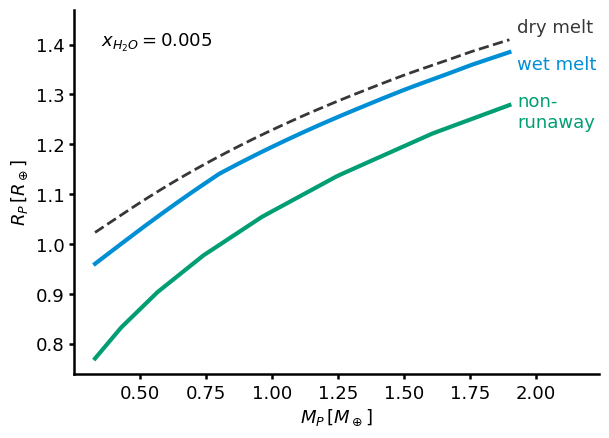

In [693]:
# check if M-R relation looks good:
dd = sample.to_pandas()
d = dd.sample(min([len(dd), 4000]))
mo = dd[dd.has_magmaocean].sample(min([len(dd[dd.has_magmaocean]), 4000]))

fig, ax = plt.subplots()
# plt.scatter(mo.M, mo.R_orig, s=1., label='original radius', c='gray')
# plt.scatter(mo.M, mo.R, s=1., label='new radius')
# plt.scatter(mo.M, mo.R - mo.R_orig, s=1., label='$\Delta R$', alpha=.4)


def interpolate_MR(df, colname):
    # interpolate M-R relation
    return interp1d(df.M, df[colname], kind='quadratic')

M = np.linspace(0.33, 1.9, num=200)
try:
    # ax.scatter(mo.M, mo.R_steam, s=2., label='B) dry melt', c='C1')
    ax.plot(M, interpolate_MR(mo.sort_values('M'), 'R_steam')(M),
            lw=2., label='dry melt', c='xkcd:dark grey', ls='--')
except AttributeError:
    pass
# ax.scatter(mo.M, mo.R, s=2., label='C) wet melt', c='C2')
ax.plot(M, interpolate_MR(mo.sort_values('M'), 'R')(M),
        lw=3., label='wet melt', c='C2')

# ax.plot(d.sort_values('M').M, d.sort_values('M').R_orig, lw=2, label='A) non-runaway GH', c='C0')
ax.plot(M, interpolate_MR(d.sort_values('M'), 'R_orig')(M),
        lw=3., label='non-\nrunaway', c='C0')

ax.set_xlabel('$M_P \,[M_\oplus]$')
ax.set_ylabel('$R_P \,[R_\oplus]$')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.legend(loc='lower right', ncol=1, bbox_to_anchor=(1.01, 0.01),
                              # frameon=False, columnspacing=1.6, markerscale=3)
ax.annotate('$x_{{H_2O}}= ${}'.format(planets_args['wrr']), xy=(0.05,.9), xycoords='axes fraction')
ax.set_xlim(right=2.24)
ax.set_ylim(top=1.47)

for y, lbl, c in zip([max(mo.R_steam)+0.01, max(mo.R)-0.04, max(d.R_orig)-0.03], 
                     ax.get_legend_handles_labels()[1], ['xkcd:dark grey', 'C2', 'C0']):
    ax.annotate(lbl, xy=(1.93, y), c=c, va='center')

radius_change = np.average(mo.R/mo.R_orig) - 1
print('avg radius change of runaway GH planets: {:+.0f} %'.format(100*radius_change))
density_change = np.average(mo.rho/(CONST['rho_Earth']*mo.M/mo.R_orig**3)) - 1
print('avg density change of runaway GH planets: {:+.0f} %'.format(100*density_change))

In [694]:
# fig.savefig(figdir + 'radiuscomparison.pdf')
# fig.savefig(paths.static / 'radiuscomparison.pdf')

## compare avg delta R/rho with expected from atmosphere models

Measure delta R as a function of water mass fraction (fitted from data measured in simulated rgh planets, `avg_deltaR_deltaRho.csv`)

Text(0.002382459421658162, 0.08, 'b = 0.26')

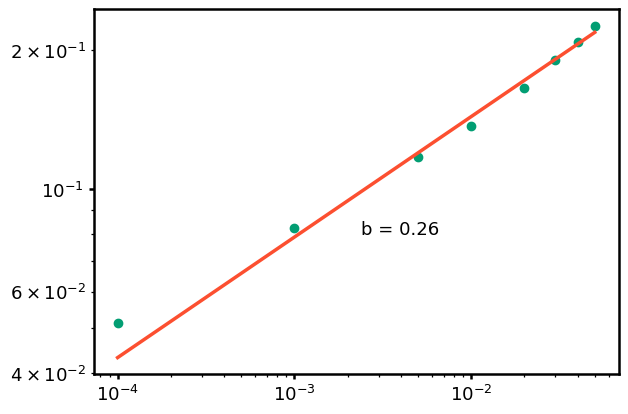

In [860]:
from scipy.optimize import curve_fit
from scipy.interpolate import LinearNDInterpolator, griddata

# # only steam atmospheres:
# df = pd.DataFrame([
#     [0.0001,0.05057],
#     [0.001,0.109583],
#    [0.005,0.1617169],
#    [0.01,0.19000200],
#    [0.02,0.22600837],
#    [0.03,0.25259000],
#    [0.04,0.27448736],
#    [0.05,0.29371325]], columns=['wrr', 'deltaR'])

# steam atmosphere and water incorporation:
df = pd.DataFrame([
    [0.0001,0.051332],
    [0.001,0.0824150],
    [0.005,0.1171980],
    [0.01,0.13701985],
    [0.02,0.16550820],
    [0.03,0.19064582],
    [0.04,0.20806978],
    [0.05,0.22585229]], columns=['wrr', 'deltaR'])


# Function to calculate the power-law with constants a and b
def power_law(x, a, b):
    return a*np.power(x, b)

# Fit power-law and get std deviations (square roots of the # diagonal of the covariance)
pars, cov = curve_fit(f=power_law, xdata=df.wrr, ydata=df.deltaR, p0=[0, 0], bounds=(-np.inf, np.inf))
stdevs = np.sqrt(np.diag(cov))

x = np.geomspace(df.wrr.min(), df.wrr.max(), 50)
plt.scatter(df.wrr, df.deltaR)
plt.plot(x, power_law(x, *pars), c='C1')
plt.loglog()
plt.annotate('b = {:.2f}'.format(pars[1]), (x[25], 8e-2))

In [862]:
# Read M-R relations from Turbet+2020
purerock = pd.read_csv(DATA_DIR + 'mass-radius_relationships_mgsio3_Zeng2016.txt')
purerock.loc[:, 'wrr'] = 0.
turbet2020 = pd.read_csv(DATA_DIR + 'mass-radius_relationships_STEAM_TURBET2020_FIG2b.dat', comment='#')
mass_radius = purerock.append(turbet2020, ignore_index=True)

# Read radius differences from DL21 Fig. 3b
delta_R = pd.read_csv(DATA_DIR + 'deltaR_DornLichtenberg21_Fig3b.csv')
delta_R.set_index('wrr', inplace=True)

# Combine Turbet+2020 and DL21 radius diffs:
# interpolate within planet masses for the given water mass fraction wrr
x = delta_R.index.to_numpy()
y = np.array([float(c) for c in delta_R.columns])
z = delta_R.to_numpy().flatten()
grid = []
for xi in x:
    for yi in y:
        grid.append((xi, yi))
grid= np.array(grid)
interp = LinearNDInterpolator(list(grid), z)

mass_radius.loc[:,'radius_tot'] = mass_radius.radius + interp(mass_radius.wrr, mass_radius.mass)
# plt.scatter(mass_radius.radius, mass_radius.radius_tot)

# Read radius differences as measured in synthetic population
avg_deltaR_deltaRho = get_avg_deltaR_deltaRho() 

,mass,radius,wrr,radius_tot
0,0.0094,0.25330,0.00,NaN
1,0.0133,0.28310,0.00,NaN
2,0.0188,0.31670,0.00,NaN
3,0.0263,0.35330,0.00,NaN
4,0.0363,0.39260,0.00,NaN
...,...,...,...,...
371,1.8500,1.48980,0.05,1.457362
372,1.9000,1.49703,0.05,1.465189
373,1.9500,1.50426,0.05,1.473022
374,2.0000,1.51145,0.05,1.480824


(<Figure size 1200x400 with 2 Axes>,
 array([<AxesSubplot:xlabel='Water mass fraction $x_\\mathrm{H_2O}$', ylabel='$\\Delta R_\\mathrm{model} - \\langle \\Delta R_\\mathrm{population}\\rangle $'>,
        <AxesSubplot:xlabel='Water mass fraction $x_\\mathrm{H_2O}$', ylabel='$\\Delta \\rho_\\mathrm{model} - \\langle \\Delta \\rho_\\mathrm{population}\\rangle $'>],
       dtype=object))

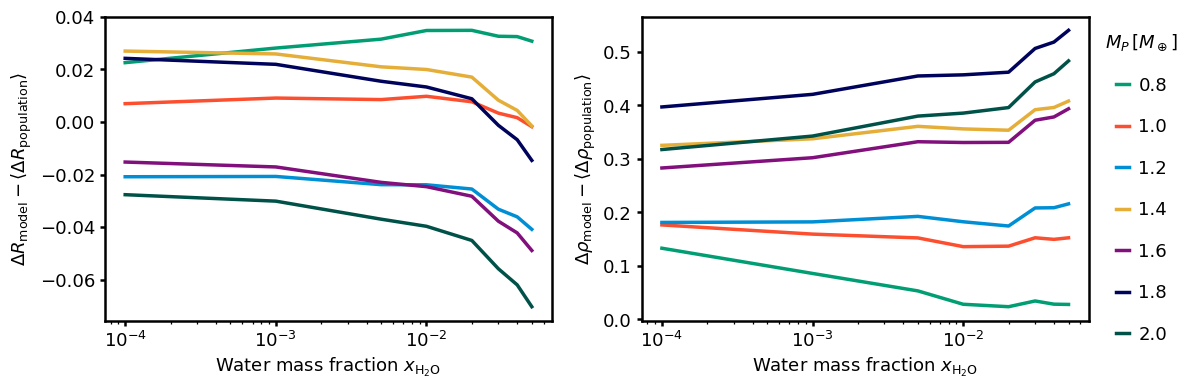

In [1043]:
target_mass = 1.0   # mass to compare in Earth masses
# target_mass = sample.to_pandas().M.mean()   # mass to compare in Earth masses

def plot_model_pop_comparison():
    fig, axs = plt.subplots(1,2, figsize=[12, 4])
    
    r2rho = lambda M, R: CONST['rho_Earth']*M/R**3 
    for i, x in enumerate(['R', 'rho']):
        ax = axs[i]
        for target_mass in np.linspace(0.8, 2., 7): 
            # compute dry radius at target mass
            mr_dry = mass_radius[mass_radius.wrr == 0.]
            mr_drym = mr_dry.iloc[(mr_dry.mass - target_mass).abs().argsort()[0],:]
            
            if x == 'R':
                dry_x = mr_drym.radius
            elif x == 'rho':
                dry_x = r2rho(mr_drym.mass, mr_drym.radius)

            wrrs = mass_radius.wrr.unique()
            dx_models = []
            dx_pop = []
            for wrri in wrrs:
                # for each water mass fraction, compute difference between model and synthetic population mean
                mrwrr = mass_radius[mass_radius.wrr == wrri]
                mrwrr.reset_index(drop=True, inplace=True)
                mrwrrm = mrwrr.iloc[(mrwrr.mass - target_mass).abs().argsort()[0],:] 
                if x == 'R':
                    dx_models.append(mrwrrm.radius_tot - dry_x)
                elif x == 'rho':
                    dx_models.append(r2rho(mrwrrm.mass, mrwrrm.radius_tot) - dry_x)
                    
                dx_pop.append(avg_deltaR_deltaRho[avg_deltaR_deltaRho.gh_increase 
                                                         & avg_deltaR_deltaRho.water_incorp & (avg_deltaR_deltaRho.wrr == wrri)]['delta_' + x])

            # plt.scatter(dx_models, dx_pop) 
            ax.plot(wrrs, np.subtract(np.array(dx_models), np.array(dx_pop).flatten()), label='{:.1f}'.format(target_mass)) 
        ax.set_xscale('log')
        ax.set_xlabel('Water mass fraction $x_\mathrm{H_2O}$')
        if x == 'R':
            ax.set_ylabel(r'$\Delta {0}_\mathrm{{model}} - \langle \Delta {0}_\mathrm{{population}}\rangle $'.format(x))
        elif x == 'rho':
            ax.set_ylabel(r'$\Delta \{0}_\mathrm{{model}} - \langle \Delta \{0}_\mathrm{{population}}\rangle $'.format(x))
    ax.legend(loc='upper left', ncol=1, bbox_to_anchor=(1.0, 1.0), title='$M_P \, [M_\oplus]$',
                   frameon=False, labelspacing=1.3)
    return fig, axs

plot_model_pop_comparison()

In [915]:

mrwrr = mass_radius[mass_radius.wrr == wrri]
mrwrr.reset_index(drop=True, inplace=True)
mrwrrm = mrwrr.iloc[(mrwrr.mass - target_mass).abs().argsort()[0],:]


# mass_radius[(mass_radius.wrr == wrri)].iloc[(mass_radius[(mass_radius.wrr == wrri)].mass - target_mass).abs().argsort().reset_index()[0],:]

KeyError: 0

In [10]:
# # show sample in period-radius:

# from matplotlib.ticker import ScalarFormatter


# talk = False 
# if talk:
#     plt.style.use('dark_background')
# else:
#     plt.style.use('default')

# yvar = parameter_of_interest

# sampledf = sample.to_pandas()
# # fig, ax = plt.subplots(figsize=[10, 6])
# fig, ax = plt.subplots()
# ax.scatter(sampledf[sampledf.transiting==False].S_abs, sampledf[sampledf.transiting==False][yvar], s=1.5, c='dimgray',alpha=.5, label='synthetic planets')

# sampledf[sampledf.transiting==False].rho

# # transiting planets
# ax.scatter(sampledf[sampledf.transiting==True].S_abs, sampledf[sampledf.transiting==True][yvar], s=20,  marker='x', c='C1', label='transiting')

# # show differences in radius due to magma ocean
# if yvar =='R':
#     X_coords= np.array([sampledf[sampledf.transiting==True].S_abs, sampledf[sampledf.transiting==True].S_abs])
#     Y_coords=np.array([sampledf[sampledf.transiting==True].R_orig, sampledf[sampledf.transiting==True].R])
#     ax.plot(X_coords, Y_coords, c='gray', lw=1.5, alpha=.5, zorder=-1)
    
#     for i in range(len(sampledf[sampledf.transiting==True])):
#         if Y_coords[1][i] != Y_coords[0][i]:
#             ax.annotate(
#               "",
#               xy=(X_coords[0][i], Y_coords[1][i]), xytext=(0, -1.),#xytext=(0., Y_coords[1][i]),
#               textcoords='offset points', ha='right', va='bottom',
#               bbox=dict(boxstyle='round,pad=0.5',  alpha=0.5),
#               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', alpha=.5, lw=1.5),
#             zorder = -9
#            )
    
#     ax.set_ylabel('Radius [$R_\oplus$]',fontsize=15)
# elif yvar == 'rho':
#     ax.set_ylabel('bulk density [$\mathrm{g/cm^3}$]',fontsize=15)
     
# # ax.text(.98, .9, 'water/rock = {:.0e}'.format(planets_args['wrr']), horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

# # ax.set_xlabel('Solar-equivalent semimajor axis [au]')
# ax.set_xlabel('Instellation [$\mathrm{W/m^2}$]',fontsize=15)
# # ax.loglog()
# ax.set_xscale('log')
# ax.legend(loc='lower left', ncol=3, bbox_to_anchor=(0.0, 1.),
#                               frameon=False, columnspacing=1.6)
# plt.xlim(50., 2000.) 
# plt.ylim(1., 1.4)

# ax.invert_xaxis()
# for axis in [ax.xaxis, ax.yaxis]:
#     axis.set_major_formatter(ScalarFormatter())

# print('N_transiting: {}'.format(len(sampledf[sampledf.transiting==True])))

In [11]:
# fig.savefig('/Users/schlecker/repos/magmaocean/src/tex/figures/synthetic_population.pdf', bbox_inches='tight')
# fig.savefig(talkfigdir + 'instellation-radius_N32.png', bbox_inches='tight', dpi=600)

Same plot with only transiting planets

In [12]:
# talk = False 
# if talk:
#     plt.style.use('dark_background')

# yvar = parameter_of_interest
# sampledf = sample.to_pandas()

# # fig, ax = plt.subplots(figsize=[10, 6])
# fig, ax = plt.subplots()
# ax.scatter(sampledf[sampledf.transiting==True].S_abs, sampledf[sampledf.transiting==True][yvar], s=20,  marker='x', c='C1', label='transiting')

# if yvar =='R':
#     ax.set_ylabel('Radius [$R_\oplus$]',fontsize=15)
# elif yvar == 'rho':
#     ax.set_ylabel('bulk density [$\mathrm{g/cm^3}$]',fontsize=15)
     
# # ax.text(.98, .9, 'water/rock = {:.0e}'.format(planets_args['wrr']), horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

# # ax.set_xlabel('Solar-equivalent semimajor axis [au]')
# ax.set_xlabel('Instellation [$\mathrm{W/m^2}$]',fontsize=15)
# # ax.loglog()
# ax.set_xscale('log')
# ax.legend(loc='lower left', ncol=3, bbox_to_anchor=(0.0, 1.),
#                               frameon=False, columnspacing=1.6)
# plt.xlim(50., 2000.) 
# plt.ylim(1., 1.4)

# ax.invert_xaxis()
# for axis in [ax.xaxis, ax.yaxis]:
#     axis.set_major_formatter(ScalarFormatter())

In [13]:
# fig.savefig(talkfigdir + 'instellation-radius_transiting.png', bbox_inches='tight', dpi=600)
# fig.savefig(talkfigdir + 'instellation-radius_N500.png', bbox_inches='tight', dpi=600)

## Explore radius-sma dependency
Let's have a look at the (effective) sma dependence of planets bearing magma oceans. Hypothesis tests are based on the average planet radius *outside* the threshold instellation S_thresh.

In [736]:
# from bioverse.hypothesis import magma_ocean_hypo, magma_ocean_f0, get_avg_deltaR_deltaRho 
# from bioverse.util import S2a_eff, a_eff2S
# from matplotlib.ticker import ScalarFormatter
# import scipy

# talk = False
# if talk:
#     plt.style.use('dark_background')

def binned_stats(df, x_param, y_param, bins, statistic='mean'):
    means, edges, n = scipy.stats.binned_statistic(df[x_param], df[y_param], 
                                             statistic=statistic, bins=bins)
    std = []
    for e_lo, e_hi in zip(edges[:-1], edges[1:]):
        std.append(np.std(df[(df[x_param] > e_lo) & (df[x_param] < e_hi)][y_param]))
    return means, edges, n, std

# # a_eff_grid = np.geomspace(0.05, 10., num=250)         # a_eff grid
# S_grid = np.linspace(50., 2000., 250)
# a_eff_grid = S2a_eff(S_grid)




# R_avg_out = np.average(sample['R'][(sample['S_abs'] < planets_args['S_thresh']) & sample['transiting']])
# R_avg_in = np.average(sample['R'][sample['S_abs'] >= planets_args['S_thresh'] & sample['transiting']])

# rho_avg_out = np.average(CONST['rho_Earth']*sample['M'][(sample['S_abs'] < planets_args['S_thresh']) & sample['transiting']]/
                         # (sample['R'][(sample['S_abs'] < planets_args['S_thresh']) & sample['transiting']])**3)
# rho_avg_in = np.average(CONST['rho_Earth']*sample['M'][sample['S_abs'] >= planets_args['S_thresh'] & sample['transiting']]/
                         # (sample['R'][sample['S_abs'] >= planets_args['S_thresh']& sample['transiting']])**3)


# P_magma = magma_ocean_hypo_step((planets_args['f_magma'], planets_args['a_cut'], 
                                 # planets_args['radius_reduction'], R_avg), a_eff_grid)
# P_magma = magma_ocean_hypo_exp((planets_args['f_magma'], planets_args['a_cut'], 
                                 # planets_args['lambda_a']), a_eff_grid)
    
# avg_deltaR_deltaRho = get_avg_deltaR_deltaRho() # import avg_deltaR_deltaRho once here to avoid a lot of file I/O during hypothesis calls
# if parameter_of_interest == 'R':
#     P_magma = magma_ocean_hypo((planets_args['S_thresh'], planets_args['wrr'], R_avg_out), a_eff_grid, 
#                                gh_increase=planets_args['gh_increase'], water_incorp=planets_args['water_incorp'],
#                                simplified=planets_args['simplified'], diff_frac=radius_change,
#                                parameter_of_interest=parameter_of_interest, avg_deltaR_deltaRho=avg_deltaR_deltaRho)
    
    
#     P0 = magma_ocean_f0(R_avg_out, a_eff_grid)
# elif parameter_of_interest == 'rho':
#     P_magma = magma_ocean_hypo((planets_args['S_thresh'], planets_args['wrr'], rho_avg_out), a_eff_grid, diff_frac=density_change,
#                                parameter_of_interest=parameter_of_interest, avg_deltaR_deltaRho=avg_deltaR_deltaRho)
#     P0 = magma_ocean_f0(rho_avg_out, a_eff_grid)

# # backtransform from a_eff to S
# S_grid = a_eff2S(a_eff_grid)

# plt.plot(S_grid, P_magma, label='H$_\mathrm{magma ocean}$', lw=3)
# plt.plot(S_grid, P0, label='H$_0$')
# plt.xscale('log')

# # plt.xlabel('Solar-equivalent semimajor axis [au]',fontsize=15)
# plt.xlabel('Instellation [$\mathrm{W/m^2}$]',fontsize=15)

# if parameter_of_interest == 'R':
#     if talk:
#         plt.ylabel('avg. planet radius [R$_\oplus$]',fontsize=15)
#     else:
#         plt.ylabel('$<R_P>$',fontsize=15)
# elif parameter_of_interest == 'rho':
#     plt.ylabel('$<\\rho>$',fontsize=15)

# fig = plt.gcf()
# ax = plt.gca()
# ax.invert_xaxis()
# for axis in [ax.xaxis, ax.yaxis]:
#     axis.set_major_formatter(ScalarFormatter())
    


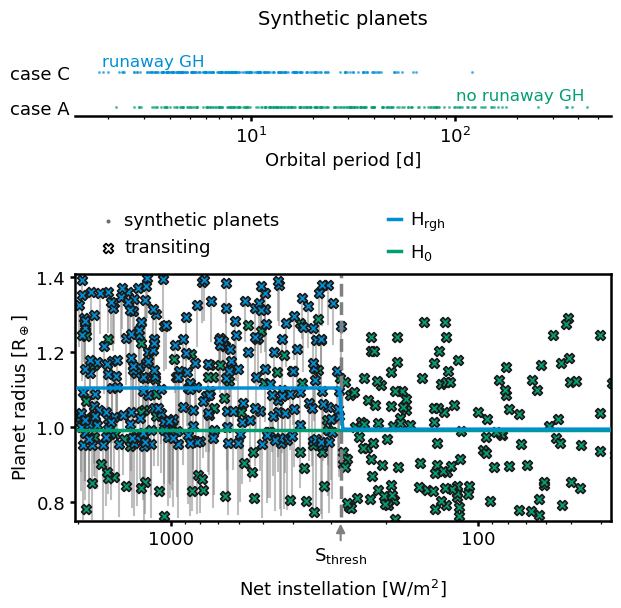

In [767]:
import HnullHmo 

# with plt.style.context('dark_background'):
if True:
    fig, (ax, ax2) = HnullHmo.main(sample, planets_args, parameter_of_interest)

    # fig.set_figheight(10)

# fig, (ax, ax2) = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [1,4]}, figsize=[6.4,6.4])
# ax = plot_has_magmaocean(sample.to_pandas().sample(min(500, len(sample)), random_state=42), ax)
# ax2 = draw_Sthresh(ax2, planets_args)
# ax2 = plot_transitingplanets(sample, planets_args, ax2, parameter_of_interest=parameter_of_interest)
# # from matplotlib import rc
# # rc('axes', linewidth=8)
# # import plotstyle
# ax2 = plot_HnullHmo(sample, planets_args, ax2, parameter_of_interest=parameter_of_interest)


# # ax2.set_xlim(2050, 37)
# # ax2.set_ylim(0.76, 1.4)
# ax.set_title('Synthetic planets', y=1.35, fontsize=14)


# #DEBUG
# # plt.scatter(100, np.average(s[~s.has_magmaocean].R)) 
# # plt.scatter(1000, np.average(s[s.has_magmaocean].R)) 


# fig.tight_layout(h_pad=2.)


# print('N_transiting: {}'.format(sample.to_pandas().transiting.sum()))

In [768]:
# fig.savefig(paths.static / "HnullHmo.pdf")

# Compute radius differences to inform hypotheses

The magma ocean hypotheses rely on measurements of average radii and bulk densities. Here, we create a table to inform the hypothesis function.

We take into account *only the transiting planets*, as these are the ones we'll be detecting (the radius differences of transiting planets differ on the percent level compared to using all planets).

-------
**This needs to be executed whenever:**
- ~~f_{rgh} changes~~ (compute_avg_deltaR_deltaRho considers only magma ocean planets)
- file `avg_deltaR_deltaRho.csv` is not available
- stars or planets are generated from a different source (e.g. different occurrence rates)
- new biases/sample limits are introduced (e.g. minimum planet radius, transit depth, ...)

-------

This is slow (~10-20min if considering stellar evo).

In [739]:
# %%time
# from bioverse.hypothesis import compute_avg_deltaR_deltaRho
# avg_deltaR_deltaRho = compute_avg_deltaR_deltaRho(stars_args, planets_args)

# # reset star, planet args for use in this notebook
# stars_args, planets_args = get_generator_args()

# # load avg_deltaR_deltaRho object in case it's needed further down
# avg_deltaR_deltaRho = get_avg_deltaR_deltaRho() 

Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
CPU times: user 30min 39s, sys: 22.1 s, total: 31min 1s
Wall time: 31min 15s


# Survey simulation

We have generated a population of synthetic planets that orbit synthetic stars and we have injected a statistical trend originating from the presence of magma oceans on some planets. Only a subset of these planets "will be detectable by a transit or direct imaging survey. For those planets, only a subset of their properties can be directly probed, and only with a finite level of precision."

In the following, we will simulate a transit survey and try to detect the (population-wide) effect on the planet radius caused by global magma oceans

## Define transit survey

let's define some key parameters of the survey: [TODO: check which ones are needed to define our transit surveys]
- ``diameter``: the diameter of the telescope primary in meters (or the area-equivalent diameter for a telescope array)
- ``t_max``: maximum amount of time across which to combine transit observations, in days
- ``N_obs_max``: maximum allowable number of transit observations per target
- ``t_slew``: slew time between observations, in days
- ``D_ref``: diameter of the reference telescope, in meters

e.g., we could choose values similar to the ones expected for the LIFE telescope array (LIFE collaboration, 2021). In the nominal configuration with four 2 m telescopes, it would have a equivalent light-collecting area of a 4 m telescope.

In [740]:
survey = TransitSurvey(diameter=8.5, t_max=3652.5, t_slew=0.1, N_obs_max=1000)
# survey = TransitSurvey(diameter=.5, t_max=3.6525, t_slew=0.1, N_obs_max=2)

Created a new TransitSurvey


Let's add some measurements our survey conducts.

In [741]:
margs = {}
mkeys = ['L_st', 'R_st', 'M_st', 'T_eff_st', 'd', 'age', 'depth', 'R', 
         'T_dur', 'P', 'a', 'a_eff', 'S', 'S_abs',
         'M', 'rho']

# # Optimistic survey: choose very optimistic values
margs['precision'] = {'T_eff_st': 25.,
                      'R_st': '1%',
                      'depth': '1%',
                      'R': '2%',
                      'M_st': '1%',
                      'age': '30%',
                      'P': 0.000001,
                      'S': '5%',
                      'S_abs': '5%',
                      'M': '5%',
                      'rho': '7%'}

# Add the measurements to s_transit
for mkey in mkeys:
    kwargs = {}
    for key, vals in margs.items():
        if mkey in vals:
            kwargs[key] = vals[mkey]
    survey.add_measurement(mkey, **kwargs)
# survey

which planets are detectable?

In [742]:
detected_opt = survey.compute_yield(sample)
N = len(detected_opt)
print(N)
save_var_latex('N_optimistic', '{:.0f}'.format(N))

497


simulate observations, obtain dataset

In [743]:
data = survey.observe(detected_opt, demographics=True)

<Figure size 640x480 with 0 Axes>

In [744]:
# yvar = parameter_of_interest
# xvar = 'S_abs'
# # yvar = 'R' 

# fig, ax = plt.subplots()
# ax.scatter(data[xvar], data[yvar], s=2, c='k')
# ax.errorbar(data[xvar], data[yvar], xerr=data.error[xvar], yerr=data.error[yvar], fmt='o', ms=2., 
#             color='k', alpha=.66, label='measured')


# ax.set_xscale('log')
# # ax.set_yscale('log')


# # plot binned stats as errorbar plot
# means, edges, n, std = binned_stats(data, xvar, yvar, np.geomspace(np.min(data[xvar]), np.max(data[xvar]), num=8), statistic='mean')
# ax.hlines(np.mean(data[yvar]), np.min(data[xvar]), np.max(data[xvar]), color='C2', ls='--', label='mean')
# ax.errorbar(edges[:-1]+(edges[1:]-edges[:-1])/2, means, xerr=(edges[1:]-edges[:-1])/2,
#            yerr=None, fmt='none', color='C1', label='binned {} statistic'.format(yvar), elinewidth=2.5)

# if xvar == 'S_abs':
#     ax.set_xlabel('Instellation [W/m2]')
#     ax.axvline(planets_args['S_thresh'], ls='-.', c='gray', alpha=.33)
#     ax.invert_xaxis()

# if yvar == 'R':
#     ax.set_ylabel('planet radius (R$_E$)')
# elif yvar == 'rho':
#     ax.set_ylabel('bulk density(g/cm3)')
    
# ax.set_title('Measured by survey ({} planets)'.format(N), y=1.15, fontsize=14)
# fig.legend(fontsize=12, loc='lower left', ncol=99, bbox_to_anchor=(0.15, .97),
#                               frameon=False, columnspacing=1.6)


# Hypothesis tests 

## define hypothesis, perform test

Sample posterior; Calculate the Bayesian evidence supporting h_magmaocean in favor of h_null from our simulated dataset.

The parameter space is complex, need to use nested sampling (not MCMC).

In [758]:
%%time
import corner
from bioverse.hypothesis import Hypothesis, magma_ocean_hypo, magma_ocean_f0, get_avg_deltaR_deltaRho 

def hypotest(data, parameter_of_interest, params, log, bounds, bounds_null, features = ('a_eff',),  binned=False, nburn=100, nlive= 500):
    
    """perform hypothesis test.
    
    Parameters
    ----------
    data : Table
        Table containing the sample of simulated planets.
    parameter_of_interest : str
        Parameter of interest, 'R' or 'rho'
    binned : bool
        if true, use the binned average radius/density; otherwise use a rolling mean.
    nburn : int
        length of burn-in phase in the nested sampling
    nlive : int
        number of live points for the nested sampling
    """
     
    
    if binned:
        labels = (parameter_of_interest + '_mean_binned',)    
    else:
        labels = (parameter_of_interest + '_mean',)    
    

    # interpolate average delta R/delta rho
    avg_deltaR_deltaRho = get_avg_deltaR_deltaRho() 
    select_mechanisms = (avg_deltaR_deltaRho.gh_increase == planets_args['gh_increase']) & (
                        avg_deltaR_deltaRho.water_incorp == planets_args['water_incorp'])
    f_dR = scipy.interpolate.interp1d(avg_deltaR_deltaRho[select_mechanisms].wrr,
                    avg_deltaR_deltaRho[select_mechanisms]['delta_' + parameter_of_interest],
                    fill_value='extrapolate')

    # define hypothesis; define null hypothesis (a broad distribution in planet radius that is independent of orbital distance)

    if parameter_of_interest == 'R':
        h_magmaocean = Hypothesis(magma_ocean_hypo, bounds, params=params, features=features, labels=labels, 
                                  log=log, gh_increase=planets_args['gh_increase'], water_incorp=planets_args['water_incorp'], 
                                  simplified=planets_args['simplified'], diff_frac=radius_change, parameter_of_interest=parameter_of_interest, f_dR=f_dR)
        h_magmaocean.h_null = Hypothesis(magma_ocean_f0, bounds_null, params=('R_avg_random',), features=features, labels=labels, log=(log[-1],))



    elif parameter_of_interest == 'rho':
        h_magmaocean = Hypothesis(magma_ocean_hypo, bounds, params=params, features=features, labels=labels, 
                                  log=log, gh_increase=planets_args['gh_increase'], water_incorp=planets_args['water_incorp'],
                                  simplified=planets_args['simplified'], diff_frac=density_change, parameter_of_interest=parameter_of_interest, f_dR=f_dR)
        h_magmaocean.h_null = Hypothesis(magma_ocean_f0, bounds_null, params=('rho_avg_random',), features=features, labels=labels, log=(log[-1],))
        

    # perform hypothesis tests

    # Sample the posterior distribution of h(theta | x, y) using a simulated data set, and compare to the null hypothesis via a model comparison metric.
    results = h_magmaocean.fit(data, return_chains=True, nburn=nburn, nlive=nlive, sampler_results=True)
    # results_opt = h_magmaocean.fit(data, return_chains=True, nburn=500, nsteps=5000, method='emcee')

    print("The evidence in favor of the hypothesis is: dlnZ = {:.1f} (corresponds to p = {:.3f})".format(
        results['dlnZ'], np.exp(-results['dlnZ'])))

    return results, h_magmaocean

params = ('S_thresh', 'wrr', 'f_rgh', 'avg')
features = ('a_eff',)
labels = (parameter_of_interest + '_mean',) 
log = (False, True, False, False)
nburn=100


# define PRIORS for the parameters in theta uniform for 'S_thresh', log-uniform for 'wrr', uniform for 'f_rgh', 'R_avg')
bounds_R = np.array([[10., 1000.0], [1e-5, 0.1], [0.0, 1.0], [.1, 15.]])
bounds_rho = np.array([[10., 1000.0], [1e-5, 0.1], [0.0, 1.0], [1., 6.]])
if parameter_of_interest == 'R':
    bounds=bounds_R
elif parameter_of_interest == 'rho':
    bounds=bounds_rho

bounds_null = np.array([bounds[-1]])            # prior bounds for null hypothesis

results_opt, h_magmaocean = hypotest(data, parameter_of_interest, params=params, log=log, bounds=bounds, 
                       bounds_null=bounds_null, features=features, binned=False)

The evidence in favor of the hypothesis is: dlnZ = 219.1 (corresponds to p = 0.000)
CPU times: user 16.8 s, sys: 213 ms, total: 17 s
Wall time: 17.1 s


show rolling mean of radius and density and their uncertainties

In [759]:
# def plot_rolling_mean(data, parameter_of_interest='R'):
#     """diagnostic plot"""
#     fig, ax = plt.subplots(figsize=[16,5])
#     ax.scatter(data['S_abs'], data[parameter_of_interest])
#     ax.plot(data.sort_by('S_abs')['S_abs'], data.sort_by('S_abs')[parameter_of_interest +'_mean'], c='C1')
#     mean = data.sort_by('S_abs')[parameter_of_interest + '_mean']
#     sem = data.error.sort_by('S_abs')[parameter_of_interest + '_mean']
#     ax.fill_between(data.sort_by('S_abs')['S_abs'], (mean-sem), (mean+sem), color='b', alpha=.1)
#     ax.plot(data.sort_by('S_abs')['S_abs'], data.error[parameter_of_interest + '_mean'] + 1, c='C3')
#     ax.set_ylabel(parameter_of_interest + '$_\mathrm{mean}$')
#     ax.set_xlabel('S [W/m2]')
#     ax.axvline(planets_args['S_thresh'], ls='-.', c='gray', alpha=.33)
#     ax.invert_xaxis()
#     ax.set_xscale('log')

# plot_rolling_mean(data, parameter_of_interest=parameter_of_interest)

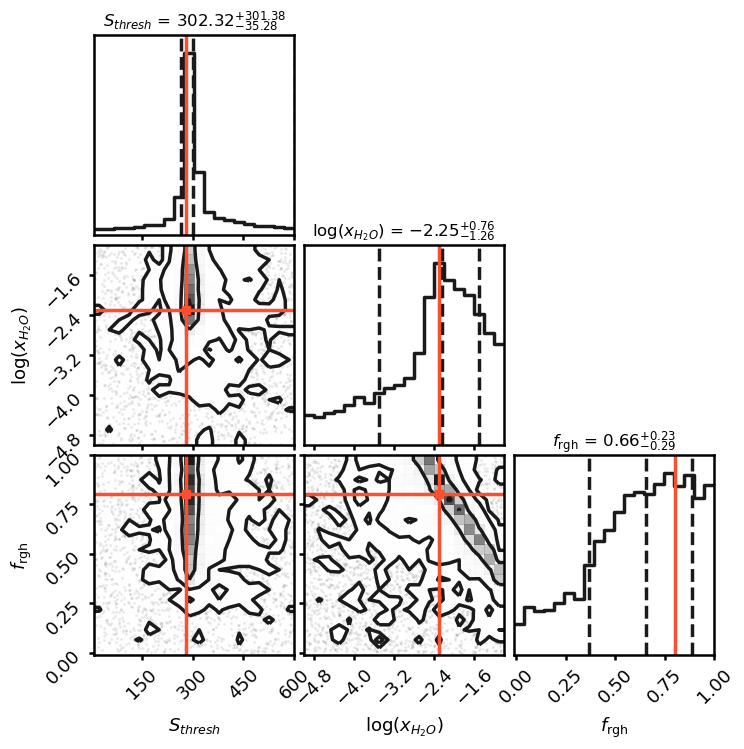

In [760]:
def cornerplot(results, params, log, planets_args, parameter_of_interest):
    # sampler_resultsn into DataFrame, make logged columns for params with log priors
    chains = pd.DataFrame(results['chains'], columns=params)
    for p, l in zip(params, log):
        if l:
            chains['log_' + p] = np.log10(chains[p])
        
    # compute truths
    if parameter_of_interest == 'R':
        avg_out = np.average(sample['R'][(sample['S_abs'] < planets_args['S_thresh']) & sample['transiting']])
    elif parameter_of_interest == 'rho':
        avg_out = np.average(CONST['rho_Earth']*sample['M'][(sample['S_abs'] < planets_args['S_thresh']) & sample['transiting']]/
                             (sample['R'][(sample['S_abs'] < planets_args['S_thresh']) & sample['transiting']])**3)
    # truths=np.array([np.log10(planets_args['S_thresh']), np.log10(planets_args['wrr']), planets_args['f_rgh'], avg_out])
    truths=np.array([planets_args['S_thresh'], np.log10(planets_args['wrr']), planets_args['f_rgh'], avg_out])

    fig = corner.corner(
                        # chains[['f_magma', 'log_a_cut', 'radius_reduction']], labels=['$\eta_{magma}$', '$\log(a_{cut})$','$f_{R_\mathrm{P}}$'],
                        # chains[['f_magma', 'log_a_cut', 'lambda_a']], labels=['$\eta_{magma}$', '$\log(a_{cut})$','$\lambda_a$'],
                        # chains[['f_magma', 'log_a_cut', 'radius_reduction','R_avg']], labels=['$\eta_{magma}$', '$\log(a_{cut})$','$f_{R_\mathrm{P}}$', 'R$_{avg}$'],
                        # chains[['log_S_thresh', 'log_wrr', 'f_rgh', 'avg']], labels=['$\log(S_{thresh})$', '$\log(x_{H_2O})$', '$f_\mathrm{rgh}$', parameter_of_interest + '$_{avg}$'],
                        # chains[['log_S_thresh', 'log_wrr', 'f_rgh']], labels=['$\log(S_{thresh})$', '$\log(x_{H_2O})$', '$f_\mathrm{rgh}$'],
                        chains[['S_thresh', 'log_wrr', 'f_rgh']], labels=['$S_{thresh}$', '$\log(x_{H_2O})$', '$f_\mathrm{rgh}$'],
                        # truths=truths, truth_color='orangered'
                        truths=truths[:-1], truth_color='C1',
                        range=[(10,600), (-5, -1.), (-0.01, 1.)],
                        quantiles=[0.16, 0.5, 0.84],
                        show_titles=True, title_kwargs={"fontsize": 12},
                        hist_bin_factor=2.,
                        smooth=.1,
                        smooth1d=.1
                        # truths=[planets_args['f_magma'], np.log10(planets_args['a_cut']), planets_args['lambda_a']], truth_color='orangered'
                        # truths=[planets_args['f_magma'], np.log10(planets_args['a_cut']), planets_args['radius_reduction'], R_avg], truth_color='orangered'
                        )

    # fig.set_facecolor('white')
    return fig

fig = cornerplot(results_opt, params, log, planets_args, parameter_of_interest)
# fig = cornerplot(results_opt, params[:-1], log[:-1], planets_args, parameter_of_interest)

In [762]:
# fig.savefig(paths.static / 'corner.pdf')

## Sampling diagnostics

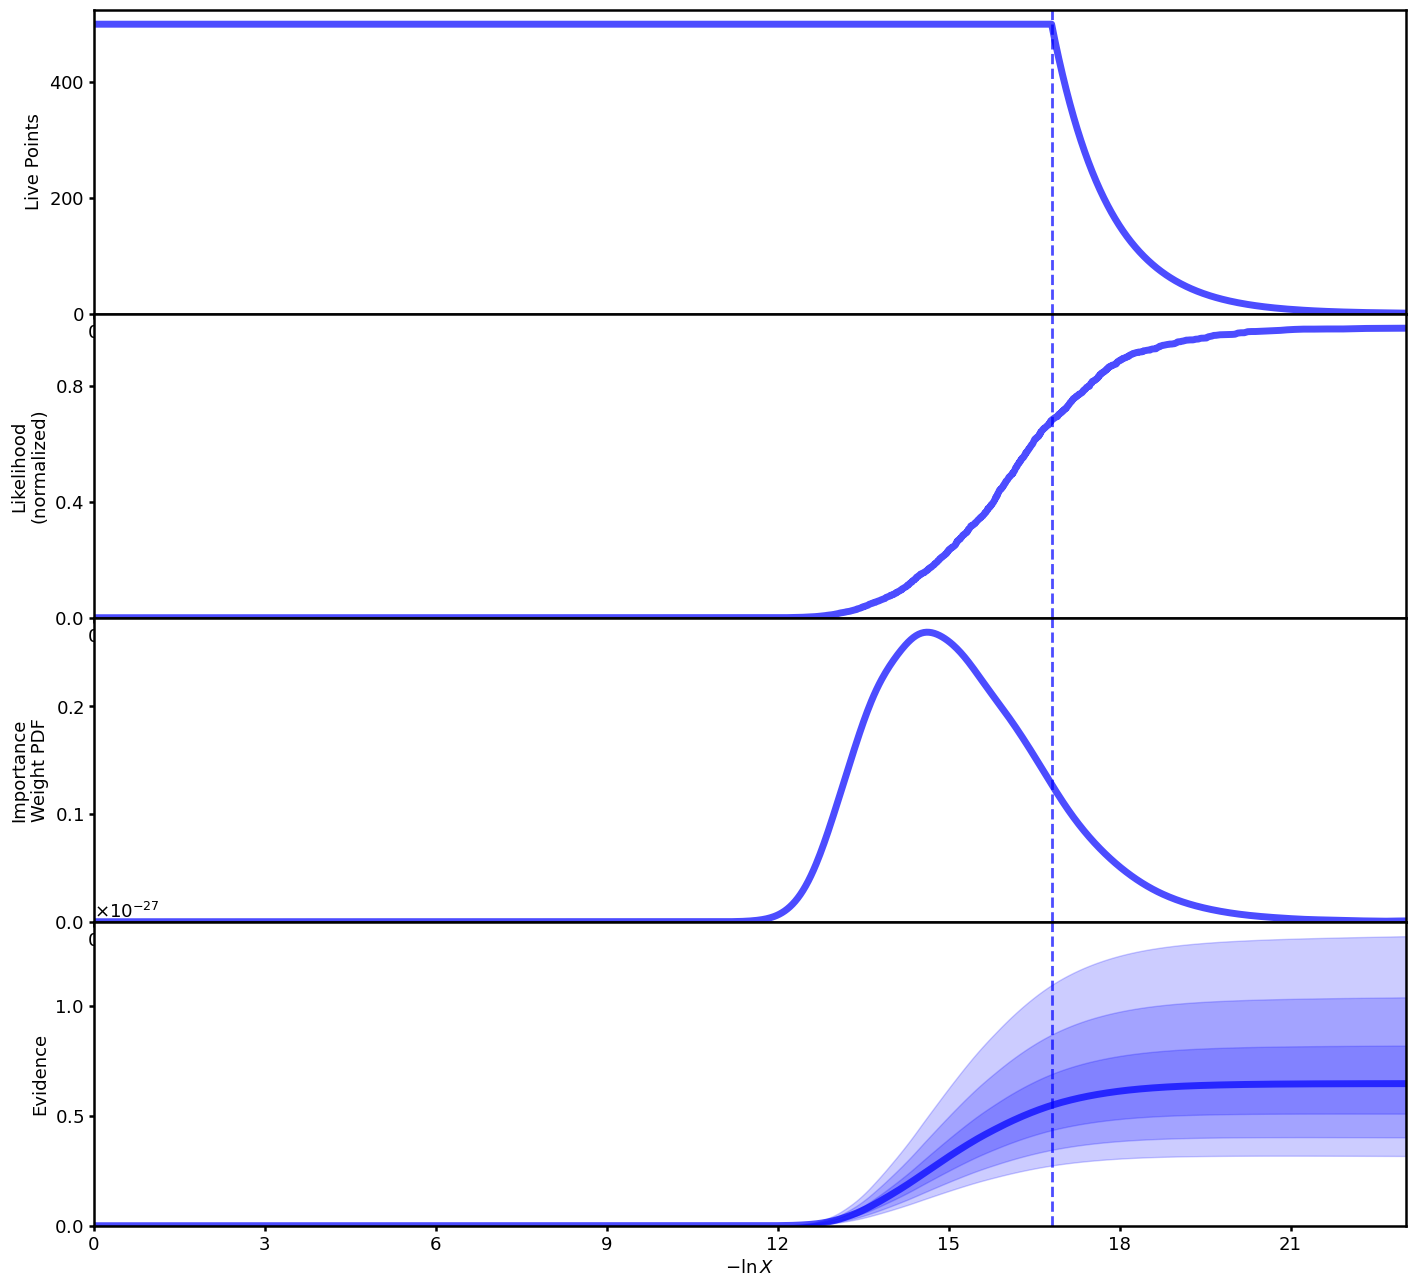

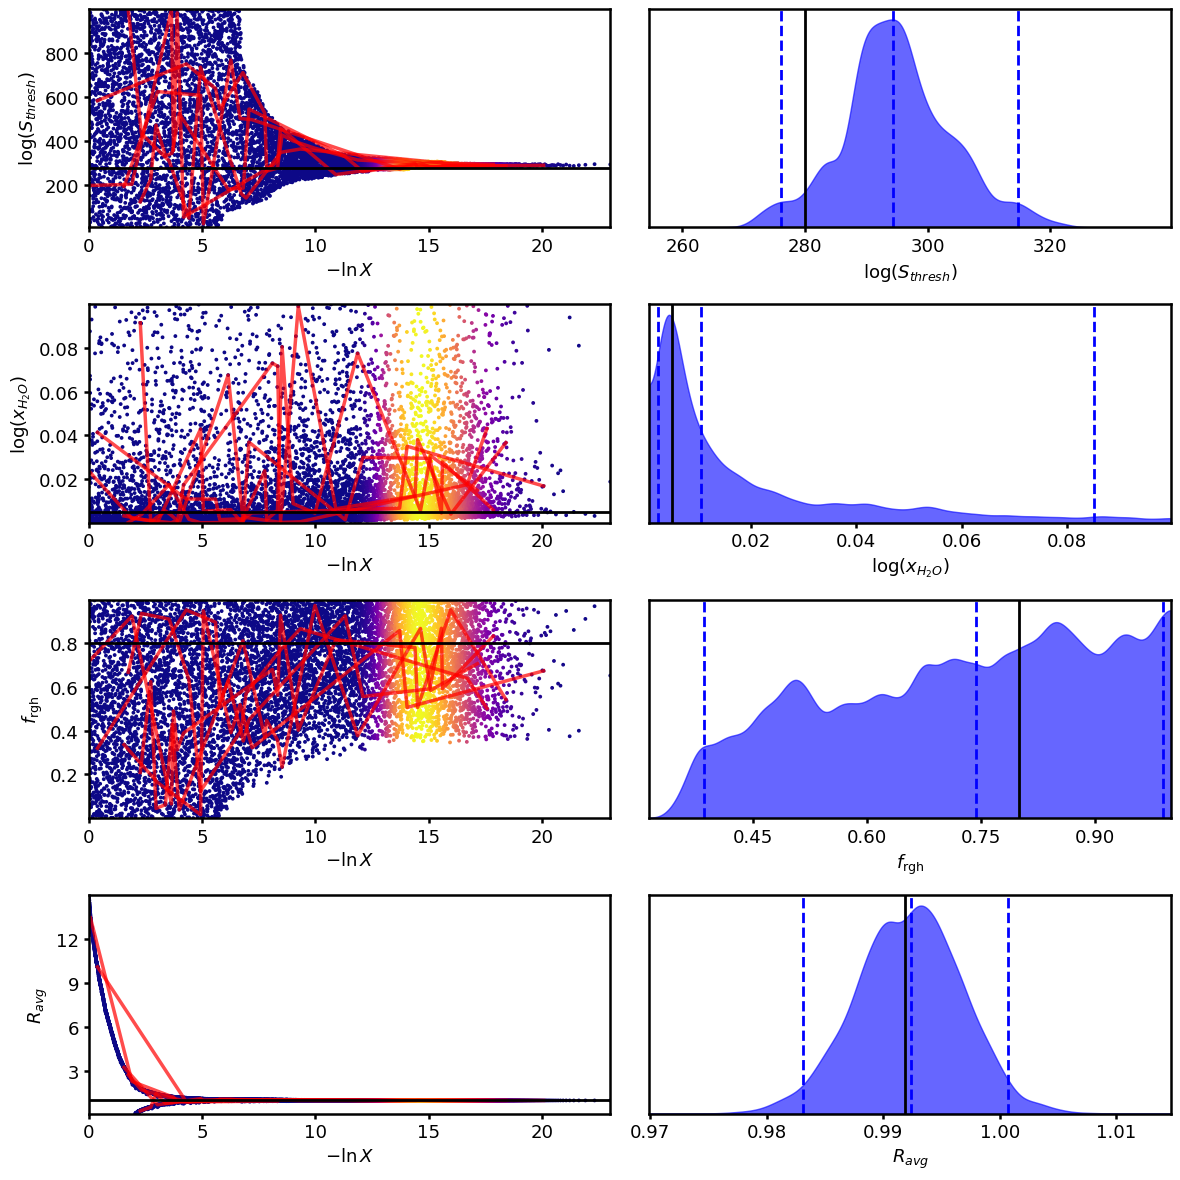

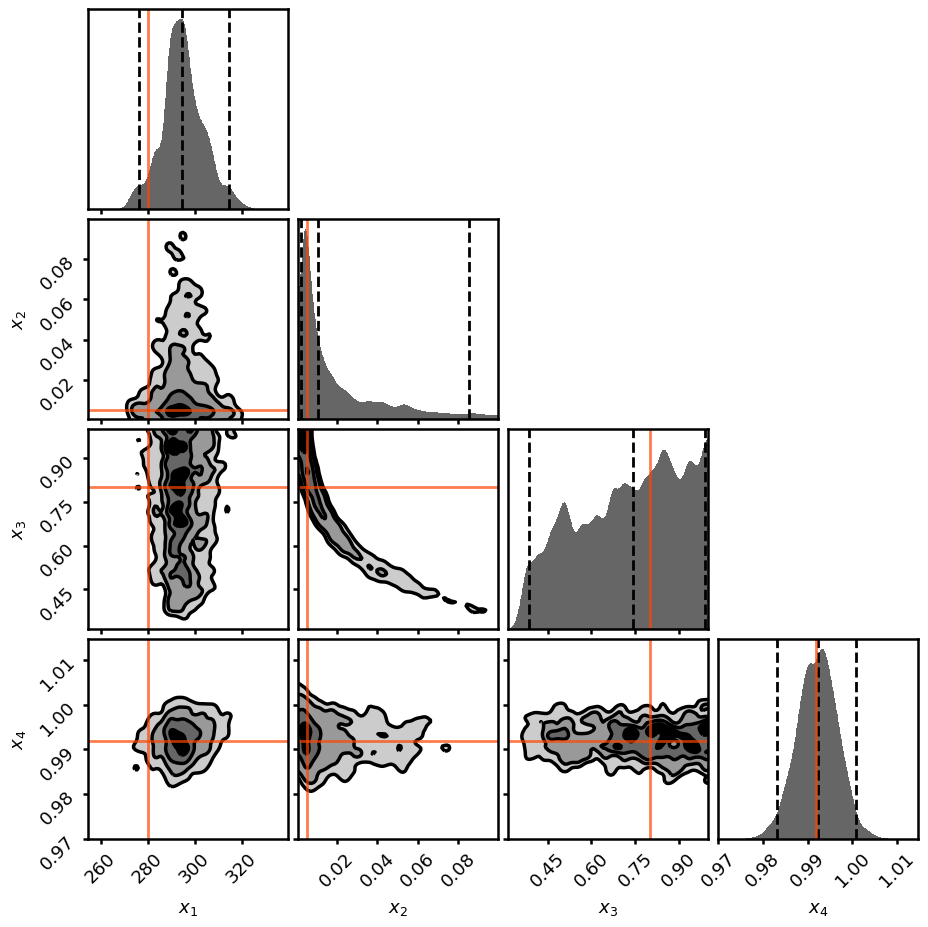

In [749]:
from dynesty import plotting as dyplot

sampler_results = results_opt['sampler_results']

# compute truths
if parameter_of_interest == 'R':
    avg_out = np.average(sample['R'][(sample['S_abs'] < planets_args['S_thresh']) & sample['transiting']])
elif parameter_of_interest == 'rho':
    avg_out = np.average(CONST['rho_Earth']*sample['M'][(sample['S_abs'] < planets_args['S_thresh']) & sample['transiting']]/
                         (sample['R'][(sample['S_abs'] < planets_args['S_thresh']) & sample['transiting']])**3)
# truths=np.array([np.log10(planets_args['S_thresh']), np.log10(planets_args['wrr']), planets_args['f_rgh'], avg_out])
truths=np.array([planets_args['S_thresh'], np.log10(planets_args['wrr']), planets_args['f_rgh'], avg_out])
exp_truths = [10**t if l else t for t, l in zip(truths, log)]


plotlabels=['$\log(S_{thresh})$', '$\log(x_{H_2O})$', '$f_\mathrm{rgh}$', '${}_{{avg}}$'.format(parameter_of_interest)]
        
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sampler_results)

# Plot traces and 1-D marginalized posteriors.
tfig, taxes = dyplot.traceplot(sampler_results, truths=exp_truths, truth_color='black', connect=True,
                             connect_highlight=range(5), labels=plotlabels)
plt.tight_layout()

# Plot the 2-D marginalized posteriors.
cfig, caxes = dyplot.cornerplot(sampler_results, truths=exp_truths, truth_color='orangered')

show samples from the posterior

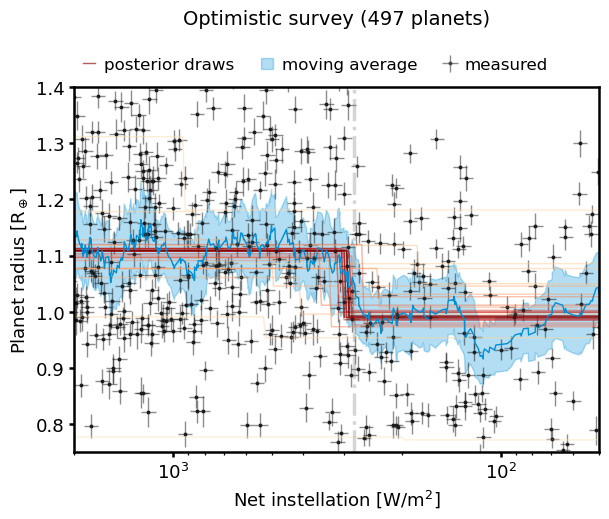

In [769]:
# %matplotlib widget

from bioverse.util import S2a_eff

def plot_survey(data, results, parameter_of_interest, show_rolling_mean=True, show_binned_stats=False):
    
    yvar = parameter_of_interest
    xvar = 'S_abs'
    # yvar = 'R' 

    fig, ax = plt.subplots()
    ax.scatter(data[xvar], data[yvar], s=2, c='k')
    ax.errorbar(data[xvar], data[yvar], xerr=data.error[xvar], yerr=data.error[yvar], fmt='o', ms=2., elinewidth=1, 
                color='k', alpha=.5, label='measured')

    if show_binned_stats:
        # means, edges, n, std = binned_stats(data, xvar, yvar, np.geomspace(np.min(data[xvar]), 
                                                                           # np.max(data[xvar]), num=12), statistic='mean')
        # ax.errorbar(edges[:-1]+(edges[1:]-edges[:-1])/2, means, xerr=(edges[1:]-edges[:-1])/2,
                   # yerr=None, fmt='none', color='C2', label='binned {} statistic'.format(yvar), elinewidth=2.5)
        binned_avg = data[yvar + '_mean_binned'] 
        ax.plot(data[xvar], binned_avg, color='C2', label='binned average')
        std = data.error[yvar + '_mean_binned']
        ax.fill_between(data.sort_by('S_abs')['S_abs'], (binned_avg-std), 
                        (binned_avg+std), color='C2', alpha=.3)

    # overplot samples from the posterior
    sampler_results = results['sampler_results']
    posterior_sample = sampler_results.samples[nburn::300]

    S_grid = np.geomspace(10., 2000., 300)
    a_eff_grid = S2a_eff(S_grid)

    colors = plt.cm.OrRd(np.linspace(0, 1, len(posterior_sample)))
    for i, s in enumerate(posterior_sample):
        P_magma = magma_ocean_hypo((s[0], s[1], s[2], s[3]), a_eff_grid,
                                   gh_increase=planets_args['gh_increase'], water_incorp=planets_args['water_incorp'],
                                   simplified=planets_args['simplified'], parameter_of_interest=parameter_of_interest)
        ax.plot(S_grid, P_magma, 
                c=colors[i],
                # c='k',
                alpha=.5, lw=1.)
    ax.plot(S_grid, P_magma, 
            c=colors[i],
    #         # c='k',
            alpha=.63, lw=1., label='posterior draws')


    ax.set_xscale('log')
    # ax.set_yscale('log')
    if xvar == 'S_abs':
        ax.set_xlabel('Net instellation [$\mathrm{W/m^2}$]')
        ax.axvline(planets_args['S_thresh'], ls='-.', c='gray', alpha=.33)
        ax.invert_xaxis()
    if yvar == 'R':
        ax.set_ylabel('Planet radius [R$_\oplus$]')
    elif yvar == 'rho':
        ax.set_ylabel('bulk density(g/cm3)')

    if show_rolling_mean:
        # add confidence interval of rolling mean radius
        mean = data.sort_by('S_abs')[parameter_of_interest + '_mean']
        sem = data.error.sort_by('S_abs')[parameter_of_interest + '_mean']
        ax.plot(data.sort_by('S_abs')['S_abs'], mean, 
                        color='C2', lw=1)
        ax.fill_between(data.sort_by('S_abs')['S_abs'], (mean-sem), 
                        (mean+sem), color='C2', alpha=.3, label='moving average')


    ax.set_title('Optimistic survey ({} planets)'.format(len(data)), y=1.15, fontsize=14)
    fig.legend(fontsize=12, loc='lower left', ncol=99, bbox_to_anchor=(0.15, .97),
                                  frameon=False, columnspacing=1.6)

    # ax.axhline(0.98, color='C2', ls='--', label='mean')

    ax.set_xlim(2000,50.)
    ax.set_ylim(0.75, 1.4)
    # ax.set_ylim(1.8, 5.)
    return fig, ax
    
fig, ax = plot_survey(data, results_opt, parameter_of_interest, show_rolling_mean=True, show_binned_stats=False)

In [770]:
# fig.savefig(paths.static / 'optimistic_R-S.pdf')

# Statistical Power
Test sensitivity on Poisson uncertainty, e.g. the specific realization of a survey.

In [771]:
from bioverse import analysis, plots

In [772]:
# %%time

# # d_grid = np.round(np.geomspace(30, 70, 8))
wrr_grid = [0., 0.0001,0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]
reduced_args = {key: planets_args[key] for key in planets_args if (key != 'wrr')} # remove keys used in the grid



# # results_stpwrgrid = analysis.test_hypothesis_grid(h_magmaocean, g_transit, survey, d_max=d_grid, N=20, processes=8, **planets_args)
# results_stpwrgrid = analysis.test_hypothesis_grid(h_magmaocean, g_transit, survey, wrr=wrr_grid, N=4, processes=8, **reduced_args)

# # Determine the statistical power assuming a significance threshold of dlnZ > 3
# power = analysis.compute_statistical_power(results_stpwrgrid, method='dlnZ', threshold=3)
# print("The statistical power of the survey is {:.1f}%".format(100*power))

In [773]:
# # plt.plot(S_thresh_grid, results_stpwrgrid['dlnZ'].mean(axis=-1), lw=5)
# plt.plot(wrr_grid, results_stpwrgrid['dlnZ'].mean(axis=-1), lw=5)
# # plt.plot(d_grid, results_stpwrgrid['dlnZ'].mean(axis=-1), lw=5)
# # plt.plot(results_stpwrgrid['N_pl'].mean(axis=-1), results_stpwrgrid['dlnZ'].mean(axis=-1), lw=3)

# percentiles = np.percentile(results_stpwrgrid['dlnZ'], [5., 95.], axis=1)    # 5% and 95% percentiles

# # lns2 = plt.fill_between(results_stpwrgrid['N_pl'].mean(axis=-1),
# #                      percentiles[0],
# #                      percentiles[1],
# #                      color=(0.45, 0.65, 0.9), alpha=.5,
# #                      label="90% prediction interval")

# # plt.xlabel('S_thresh', fontsize=20)
# plt.xlabel('water fraction', fontsize=20)
# # plt.xlabel('d_max', fontsize=20)
# # plt.xlabel('Sample size $N_\mathrm{planets}$', fontsize=20)

# plt.ylabel('$\Delta$lnZ', fontsize=20)
# plt.axhline(3, lw=2, c='black', linestyle='dashed')
# plt.annotate('$\Delta$lnZ = 3', (220, 2), va='top', ha='right')
# # plt.xscale('log')
# plt.yscale('symlog')
# # plt.xlim(20, 50)
# # plt.ylim(1e-5, 20)

# # plt.loglog()
# plt.legend()

## statistical power grid
This is very slow: **up to 5h** for a grid of 8x8 and N=20

In [775]:
wrr_grid = [0., 0.0001,0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]
# wrr_grid = [0.0001, 0.005, 0.05]
f_rgh_grid = np.linspace(0., 1., len(wrr_grid))

In [776]:
%%time
wrr_grid = [0., 0.0001,0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]
# wrr_grid = [0.0001, 0.005, 0.05]
f_rgh_grid = np.linspace(0., 1., len(wrr_grid))

reduced_args = {key: planets_args[key] for key in planets_args if (key != 'wrr') & (key != 'f_rgh')} # remove keys used in the grid
# results_grid = analysis.test_hypothesis_grid(h_magmaocean, g_transit, survey, wrr=wrr_grid, f_rgh=f_rgh_grid, N=20, processes=8, **reduced_args)
results_grid = analysis.test_hypothesis_grid(h_magmaocean, g_transit, survey, wrr=wrr_grid, f_rgh=f_rgh_grid,
                                             N=20, processes=8, return_chains=True, **reduced_args)

  5%|███████████▍                                                                                                                                                                                                       | 88/1620 [30:21<8:48:24, 20.70s/it]
Traceback (most recent call last):
  File "/Users/schlecker/repos/Bioverse/bioverse/analysis.py", line 51, in test_hypothesis_grid
    res = procs[idx].get()
  File "/Users/schlecker/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 765, in get
    self.wait(timeout)
  File "/Users/schlecker/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 762, in wait
    self._event.wait(timeout)
  File "/Users/schlecker/opt/anaconda3/lib/python3.9/threading.py", line 574, in wait
    signaled = self._cond.wait(timeout)
  File "/Users/schlecker/opt/anaconda3/lib/python3.9/threading.py", line 312, in wait
    waiter.acquire()
KeyboardInterrupt



Interrupted, terminating remaining processes
CPU times: user 609 ms, sys: 1.28 s, total: 1.89 s
Wall time: 30min 21s


In [ ]:
pickle.dump(results_grid, open(paperdatadir + 'bioverse_objects/optimistic_H2O-f-grid_G16.pkl','wb'))

# with open(paperdatadir + 'bioverse_objects/optimistic_H2O-f-grid.pkl', 'rb') as f:
# with open(paperdatadir + 'bioverse_objects/optimistic_H2O-f-grid_G16.pkl', 'rb') as f:
    # results_grid = pickle.load(f)

plot statistical power grid
(if this breaks, change zoom_factor/smooth_sigma)

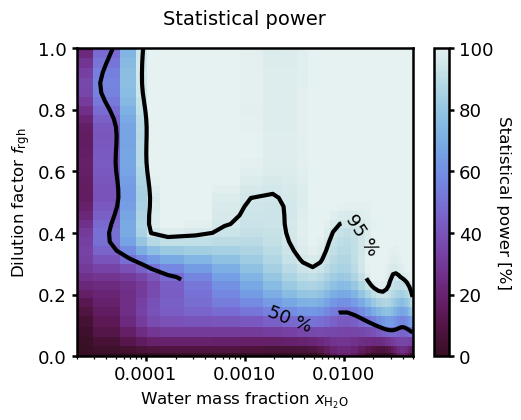

In [183]:
import cmocean

zoom_factor=4

# with plt.style.context('dark_background'):
if True:

    fig, ax = plt.subplots(figsize=[6,4])
    labels= ('Water mass fraction $x_\mathrm{H_2O}$', 'Dilution factor $f_\mathrm{rgh}$')
    fig, ax = plots.plot_power_grid(results_grid, method='dBIC', axes=('wrr', 'f_rgh'), labels=labels, 
                                    log=(True, False), show=False, fig=fig, ax=ax, 
                                    # zoom_factor=2, smooth_sigma=.5,
                                    zoom_factor=0, smooth_sigma=.2,
                                    levels=[50, 95], cmap=cmocean.cm.dense_r)

    # workaround for smoothing, necessary when a parameter = 0 in the logged grid
    plt.close()
    from scipy.ndimage import zoom

    qm = ax.get_children()[0]
    z = qm.get_array().reshape(qm._meshWidth, qm._meshHeight)
    z[z<20] = 0.       # set low values to zero to account for fluctuations
    
    
    z = zoom(z, zoom_factor, mode='nearest')
    x = zoom(wrr_grid, zoom_factor, mode='nearest')
    y = zoom(f_rgh_grid, zoom_factor, mode='nearest')

    fig, ax = plt.subplots(figsize=[6,4])
    fig, ax = plots.image_contour_plot(x, y, z, colorbar=True, labels=(*labels, 'Statistical power (%)'), 
                                       fmt=' %.0f %% ', levels=[50, 95], ticks=4, log=(True, False), 
                                       fig=fig, ax=ax, return_ctr=False, zoom_factor=None, cmap=cmocean.cm.dense_r,
                                       plus=False, smooth_sigma=0, vmin=0., vmax=100)

    # ax.set_xlim(1e-5, wrr_grid[-1])
    ax.set_xlim(2e-5, 0.05)
    ax.set_ylim(0, 1)
    # ax.set_xscale('linear')
    # ax.set_ylim(0., 1.)
    # ax.get_xaxis().set_major_formatter(ScalarFormatter())

    ax.set_xlabel(labels[0], fontsize=12)
    ax.set_ylabel(labels[1], fontsize=12)
    # ax.set_title('Optimistic survey ({} planets)'.format(N), y=1.05, fontsize=14)
    ax.set_title('Statistical power', y=1.05, fontsize=14)
    ax.collections[0].colorbar.set_label('Statistical power [%]', fontsize=12, labelpad=13.)

In [402]:
# fig.savefig(paths.static / 'optimistic_statpwr_H2O-f.pdf')

# PLATO
explore capability of the PLATO survey

In [584]:
plato = TransitSurvey()

margs = {}
mkeys = ['L_st', 'R_st', 'M_st', 'T_eff_st', 'd', 'age', 'depth', 'R', 
         'T_dur', 'P', 'a', 'a_eff', 'S', 'S_abs',
         'M', 'rho']
margs['precision'] = {'T_eff_st': 50.,
                      'R_st': '5%',
                      'depth': '0.005%', # Matuszewski et al., in prep., plato2017
                      'R': '3%', # Rauer2021
                      'M_st': '1%',
                      'age': '10%', # Rauer2021
                      'P': 0.00001,
                      'S': '10%',
                      'S_abs': '10%',
                      'M': '10%', # Rauer2021
                      'rho': '13.5%'} # error propagation from M, R errors.
for mkey in mkeys:
    kwargs = {}
    for key, vals in margs.items():
        if mkey in vals:
            kwargs[key] = vals[mkey]
    plato.add_measurement(mkey, **kwargs)

Created a new TransitSurvey


In [585]:
detected = plato.compute_yield(sample)
data_plato = plato.observe(detected, demographics=True)

results_plato = h_magmaocean.fit(data_plato, return_chains=True, nburn=nburn, 
                                 nlive=nlive, sampler_results=True)
 
print("The evidence in favor of the hypothesis is: dlnZ = {:.1f} (corresponds to p = {:.3f})".format(
    results_plato['dlnZ'], np.exp(-results_plato['dlnZ'])))

The evidence in favor of the hypothesis is: dlnZ = 98.6 (corresponds to p = 0.000)


## stat. power of different survey designs
For several versions of PLATO, show $\Delta \ln Z (f_{rgh}$)

**can load previous run from file below**

In [37]:
N_runs = 50   # number of randomized runs for each hypothesis grid point
# N_runs = 5   # number of randomized runs for each hypothesis grid point
num_grid = 11 # number of points in the grid
# num_grid = 7 # number of points in the grid
N_processes = 8


# # f_grid = np.linspace(0., 1., 10)
f_grid = np.linspace(0., 1., num_grid)

### nominal PLATO

Run hypothesis test grids, save results to file:

In [587]:
# take some breaks to recharge battery
import time
time.sleep(3600)

In [588]:
%%time
reduced_args = {key: val for key, val in planets_args.items() if key != 'f_rgh'}


res_fg_plato = analysis.test_hypothesis_grid(h_magmaocean, g_transit, plato, f_rgh=f_grid,
                                        N=N_runs, processes=N_processes, return_chains=True,
                                        **reduced_args)
# pwr_fg_plato = analysis.compute_statistical_power(res_fg_plato, method='dlnZ', threshold=3)
pickle.dump(res_fg_plato, open(paperdatadir + 'bioverse_objects/plato_f-grid.pkl','wb'))
N_plato = np.rint(res_fg_plato['N_pl'].mean())
save_var_latex('N_plato', '{:.0f}'.format(N_plato))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 550/550 [1:12:28<00:00,  7.91s/it]

CPU times: user 1.38 s, sys: 702 ms, total: 2.08 s
Wall time: 1h 12min 28s


In [589]:
time.sleep(3600)

### a PLATO mission with a smaller sample size
Run hypothesis test grids, save results to file:

In [590]:
%%time
g_100 = generate_generator(d_max=55)
res_fg_plato100 = analysis.test_hypothesis_grid(h_magmaocean, g_100, plato, f_rgh=f_grid,
                                        N=N_runs, processes=N_processes, return_chains=True, 
                                        **reduced_args)

g_40 = generate_generator(d_max=39)
res_fg_plato40 = analysis.test_hypothesis_grid(h_magmaocean, g_40, plato, f_rgh=f_grid,
                                        N=N_runs, processes=N_processes, return_chains=True, 
                                        **reduced_args)

pickle.dump(res_fg_plato100, open(paperdatadir + 'bioverse_objects/plato100_f-grid.pkl','wb'))
pickle.dump(res_fg_plato40, open(paperdatadir + 'bioverse_objects/plato40_f-grid.pkl','wb'))

Created a new Generator


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 550/550 [36:51<00:00,  4.02s/it]

Created a new Generator



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 550/550 [21:26<00:00,  2.34s/it]

CPU times: user 2.42 s, sys: 1.23 s, total: 3.65 s
Wall time: 58min 18s


In [591]:
time.sleep(3600)

### a PLATO mission with follow-up 
(bulk density-based hypothesis tests)

(have to redefine hypotheses for this step) 

Run hypothesis test grids, save results to file:

In [592]:
%%time

# Define hypothesis bounds
labels_R = ('R_mean',)
labels_rho = ('rho_mean',)    
bounds_R = np.array([[10., 1000.0], [1e-5, 0.1], [0.0, 1.0], [.1, 15.]])
bounds_rho = np.append(bounds_R[:-1,:], [[1., 6.]], axis=0)
bounds_null_R = np.array([bounds_R[-1]]) 
bounds_null_rho = np.array([bounds_rho[-1]]) 


# interpolate average delta R/delta rho
avg_deltaR_deltaRho = get_avg_deltaR_deltaRho() 
select_mechanisms = (avg_deltaR_deltaRho.gh_increase == planets_args['gh_increase']) & (
                    avg_deltaR_deltaRho.water_incorp == planets_args['water_incorp'])
f_dR_rho = scipy.interpolate.interp1d(avg_deltaR_deltaRho[select_mechanisms].wrr,
                avg_deltaR_deltaRho[select_mechanisms]['delta_rho'],
                fill_value='extrapolate')

h_magmaocean_rho = Hypothesis(magma_ocean_hypo, bounds_rho, params=params, features=features, labels=labels_rho, 
                              log=log, gh_increase=planets_args['gh_increase'], water_incorp=planets_args['water_incorp'],
                              simplified=planets_args['simplified'], diff_frac=density_change, parameter_of_interest='rho', f_dR=f_dR_rho)
h_magmaocean_rho.h_null = Hypothesis(magma_ocean_f0, bounds_null_rho, params=('rho_avg_random',), features=features, labels=labels_rho, log=(log[-1],))


res_fg_plato_rho = analysis.test_hypothesis_grid(h_magmaocean_rho, g_100, plato, f_rgh=f_grid,
                                        N=N_runs, processes=N_processes, return_chains=True,
                                        **reduced_args)

pickle.dump(res_fg_plato_rho, open(paperdatadir + 'bioverse_objects/plato_rho_f-grid.pkl','wb'))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 550/550 [36:19<00:00,  3.96s/it]

CPU times: user 1.23 s, sys: 601 ms, total: 1.83 s
Wall time: 36min 19s


In [593]:
time.sleep(3600)

### a PLATO mission with only FGK / M stars

Run hypothesis test grids, save results to file.
Choose `d_max` such that the *stellar* sample sizes reflect the ones in Nascimbeni+22:
- high-precision FGK (P1, P2): 15,996
<!--       - all FGK (P1, P2, P5): 329,441 -->
- M (P4): 33948

In [594]:
%%time
from bioverse.hypothesis import compute_avg_deltaR_deltaRho

# FGK
stars_kwargs = {'M_st_min': 0.562, 'd_max':70} # K7 star
stars_args_FGK, planets_args_FGK = get_generator_args()
for key, value in stars_kwargs.items():
    stars_args_FGK[key] = value
    
# first, generate stars to count them 
g_stars_FGK = generate_generator(stars_only=True, **stars_kwargs)    
stars_FGK = g_stars_FGK.generate() 
        
g_FGK = generate_generator(**stars_kwargs)
avg_deltaR_deltaRho_FGK = compute_avg_deltaR_deltaRho(stars_args_FGK, planets_args_FGK, savefile=False)
select_mechanisms = (avg_deltaR_deltaRho_FGK.gh_increase == planets_args_FGK['gh_increase']) & (
                    avg_deltaR_deltaRho_FGK.water_incorp == planets_args_FGK['water_incorp'])

for R_rho, b, b_null, labels in zip(['R', 'rho'], [bounds_R, bounds_rho], [bounds_null_R, bounds_null_rho], [labels_R, labels_rho]):
    f_dR_FGK = scipy.interpolate.interp1d(avg_deltaR_deltaRho_FGK[select_mechanisms].wrr,
                avg_deltaR_deltaRho_FGK[select_mechanisms]['delta_{}'.format(R_rho)],
                fill_value='extrapolate') 
    h_magmaocean_FGK = Hypothesis(magma_ocean_hypo, b, params=params, features=features, labels=labels, 
                                  log=log, parameter_of_interest=R_rho, f_dR=f_dR_FGK)
    h_magmaocean_FGK.h_null = Hypothesis(magma_ocean_f0, b_null, params=('{}_avg_random'.format(R_rho),), features=features, labels=labels, log=(log[-1],))
    
    res_fg_plato_FGK = analysis.test_hypothesis_grid(h_magmaocean_FGK, g_FGK, plato, f_rgh=f_grid,
                                        N=N_runs, processes=N_processes, return_chains=True,
                                        **reduced_args)
    pickle.dump(res_fg_plato_FGK, open(paperdatadir + 'bioverse_objects/plato_FGK_{}.pkl'.format(R_rho),'wb')) 
    
    
    
time.sleep(3600)

    
# repeat for M stars
stars_kwargs = {'M_st_max': 0.562, 'd_max':75} # K7 star
stars_args_M, planets_args_M = get_generator_args()
for key, value in stars_kwargs.items():
        stars_args_M[key] = value
g_stars_M = generate_generator(stars_only=True, **stars_kwargs)
stars_M = g_stars_M.generate()   
        
g_M = generate_generator(**stars_kwargs)
avg_deltaR_deltaRho_M = compute_avg_deltaR_deltaRho(stars_args_M, planets_args_M, savefile=False)
select_mechanisms = (avg_deltaR_deltaRho_M.gh_increase == planets_args_M['gh_increase']) & (
                    avg_deltaR_deltaRho_M.water_incorp == planets_args_M['water_incorp'])

for R_rho, b, b_null, labels in zip(['R', 'rho'], [bounds_R, bounds_rho], [bounds_null_R, bounds_null_rho], [labels_R, labels_rho]):
    f_dR_M = scipy.interpolate.interp1d(avg_deltaR_deltaRho_M[select_mechanisms].wrr,
                avg_deltaR_deltaRho_M[select_mechanisms]['delta_{}'.format(R_rho)],
                fill_value='extrapolate') 
    h_magmaocean_M = Hypothesis(magma_ocean_hypo, b, params=params, features=features, labels=labels, 
                                  log=log, parameter_of_interest=R_rho, f_dR=f_dR_M)
    h_magmaocean_M.h_null = Hypothesis(magma_ocean_f0, b_null, params=('{}_avg_random'.format(R_rho),), features=features, labels=labels, log=(log[-1],))
    
    res_fg_plato_M = analysis.test_hypothesis_grid(h_magmaocean_M, g_M, plato, f_rgh=f_grid,
                                        N=N_runs, processes=N_processes, return_chains=True,
                                        **reduced_args)
    pickle.dump(res_fg_plato_M, open(paperdatadir + 'bioverse_objects/plato_M_{}.pkl'.format(R_rho),'wb')) 
    
print('N_stars FGK: {}'.format(len(stars_FGK.to_pandas())))
print('N_stars M: {}'.format(len(stars_M.to_pandas())))
save_var_latex('N_stars_FGK', '{:d}'.format(len(stars_FGK)))
save_var_latex('N_stars_M', '{:d}'.format(len(stars_M)))

Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 550/550 [29:37<00:00,  3.23s/it]


Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 550/550 [52:49<00:00,  5.76s/it]


N_stars FGK: 15699
N_stars M: 33528
CPU times: user 19min 34s, sys: 23.6 s, total: 19min 57s
Wall time: 4h 3min 32s



**Load all previously saved hypothesisgrid result objects** into the namespace

In [96]:
# ======================
hypothesisgrids = {'res_fg_plato': 'plato_f-grid.pkl', 'res_fg_plato100' : 'plato100_f-grid.pkl',
           'res_fg_plato40' : 'plato40_f-grid.pkl', 'res_fg_plato_rho' : 'plato_rho_f-grid.pkl',
           'res_fg_plato_FGK_R':'plato_FGK_R.pkl', 'res_fg_plato_FGK_rho':'plato_FGK_rho.pkl', # FGK vs M
           'res_fg_plato_M_R':'plato_M_R.pkl', 'res_fg_plato_M_rho':'plato_M_rho.pkl',} # FGK vs M
for varname, path in zip(hypothesisgrids.keys(),
    [paperdatadir + 'bioverse_objects/' + fname for fname in hypothesisgrids.values()]):
    with open(path, 'rb') as f:
        loaded_obj = pickle.load(f)
        exec(varname + '= loaded_obj') 

NameError: name 'N_plato' is not defined

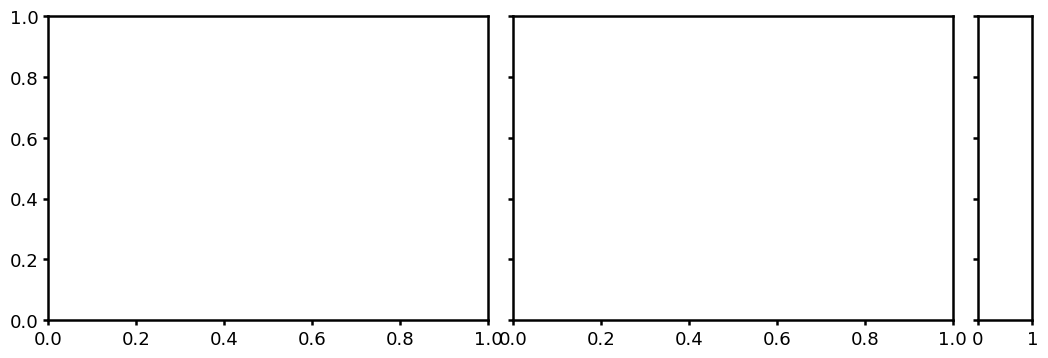

In [97]:
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

from matplotlib import lines

# def fit_poly(x, y, deg):
#     """ fit polynomial to data and return the fitted function"""
#     z = np.polyfit(x, y, deg)
#     p = np.poly1d(z)
#     return p

def plot_plato_grids(f_grid, results, labels, yaxis='dlnZ', interpolate=False, plot_percentiles=False,
                     ci_percentiles=(16., 84.), fig=None, ax=None, smooth=True, **plot_kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    if yaxis == 'dlnZ':
        y_label = 'Log-evidence difference $ \Delta \ln Z$'
        for i, (r, l) in enumerate(zip(results, labels)):
            y = r['dlnZ']
            # y_mean = np.median(y, axis=-1)
            y_mean = np.median(y, axis=-1)
            percentiles = np.percentile(y, ci_percentiles, axis=1)    # 5% and 95% percentiles
            if interpolate:
                f_grid_fine = np.linspace(min(f_grid), max(f_grid), num=60)
                interpolate_grid = interp1d(f_grid, y_mean, kind='quadratic')
                y_mean = interpolate_grid(f_grid_fine)
                # p = fit_poly(f_grid, y_mean, 3) 
                # y_mean = p(f_grid_fine)
                interpolate_p_lo = interp1d(f_grid, percentiles[0], kind='quadratic')
                interpolate_p_up = interp1d(f_grid, percentiles[1], kind='quadratic')
                percentiles = [interpolate_p_lo(f_grid_fine), interpolate_p_up(f_grid_fine)]
                x = f_grid_fine
            else:
                x = f_grid
            
            if smooth:
                # y_mean = convolve(y_mean, Gaussian1DKernel(0.8)) #Box1DKernel(3, mode='integrate'))
                y_mean = savgol_filter(y_mean, window_length=15, polyorder=2, mode='nearest')
            p = ax.plot(x, y_mean, lw=3, label=l, **plot_kwargs)
            if plot_percentiles:
                lns2 = ax.fill_between(x,
                             percentiles[0],
                             percentiles[1],
                             alpha=.15, color=p[-1].get_color())
        ax.axhline(3, lw=1, c='gray', linestyle='-')
        ax.annotate('$\Delta \ln Z$ = 3', (.97, 2.4), va='top', ha='right', c='gray')
        ax.set_yscale('symlog')
            
    elif yaxis == 'power':
        y_label = 'Statistical power [%]'
        for i, (r, l) in enumerate(zip(results, labels)):
            y = analysis.compute_statistical_power(r, threshold=None, method='dlnZ')
            ax.plot(f_grid, np.array(y)*100, lw=2,
                    label=l, **plot_kwargs)
            
    ax.set_xlabel('Dilution factor $f_\mathrm{rgh}$')
    ax.set_ylabel(y_label)
    ax.set_xlim(0, 1)
    # # plt.ylim(1e-5, 20)
    ax.legend(loc='lower left', ncol=2, bbox_to_anchor=(0.02, .98),
               frameon=False, columnspacing=6)
    return fig, ax




# plot different sample sizes and with/without follow-up
interpolate = False
smooth = True          #Apply Savgol filter (always compare with unsmoothed version to ensure no weird features are introduced)

# with plt.style.context('dark_background'):
if True:
    fig, [ax, ax1, ax2] = plt.subplots(1, 3, sharey=True, figsize=[12, 4], gridspec_kw={'wspace': 0.08, 'width_ratios':[8,8,1]})
    # fig, [ax, ax1] = plt.subplots(1, 2, sharey=True, figsize=[12, 4], gridspec_kw={'wspace': 0.1, 'width_ratios':[8,8]})
    fig, ax = plot_plato_grids(f_grid, [res_fg_plato], 
                               ['$N={:.0f}$'.format(N_plato)],
                               interpolate=interpolate, fig=fig, ax=ax, c='k')

    fig, ax = plot_plato_grids(f_grid, [res_fg_plato100], 
                               ['${N=100}$'],
                               interpolate=interpolate, fig=fig, ax=ax)
    
    fig, ax = plot_plato_grids(f_grid, [res_fg_plato40], 
                               ['${N=40}$'],
                               interpolate=interpolate, fig=fig, ax=ax, c='C4')

    fig, ax = plot_plato_grids(f_grid, [res_fg_plato_rho], 
                               ['Follow-up$_{N=100}$'],
                               # ['PLATO'],
                               interpolate=interpolate, ci_percentiles=(16,84.), 
                               fig=fig, ax=ax, linestyle=':', c='C0')


    # plot FGK vs. M
    # ================
    default_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    custom_cycle = [default_cycle[i] for i in [3,1,3,1]]

    # fig, ax = plt.subplots()
    ax1.set_prop_cycle(color=custom_cycle)

    fig, ax1 = plot_plato_grids(f_grid, [res_fg_plato_FGK_R, res_fg_plato_M_R], 
                               ['${FGK}$', '${M}$'],
                               fig=fig, ax=ax1, interpolate=interpolate)

    fig, ax1 = plot_plato_grids(f_grid, [res_fg_plato_FGK_rho, res_fg_plato_M_rho], 
                               ['Follow-up$_{FGK}$', 'Follow-up$_{M}$'],
                               # ['PLATO'],
                               interpolate=interpolate, ci_percentiles=(16,84.), 
                               fig=fig, ax=ax1, linestyle=':')

    ax.set_title('Impact of sample size', y=1.24, fontsize=15)
    ax1.set_title('FGK vs. M', y=1.24, fontsize=15)

    ax1.set_ylabel(None)
    ax1.set_xlim(left=0.01)
    ax2.axis('off') 
    ax2.set_xlim(left=-0.2)
    ax2.plot([0.,0.], [ax1.get_ylim()[0], 2.5], lw=10, c='r', alpha=.66, solid_capstyle="butt")
    ax2.text(0.3, 3., 'non-detection  ', rotation=90, va='top', c='r', alpha=.66)
    ax2.plot([0.,0.], [3.5, ax1.get_ylim()[1]], lw=10, c='g', alpha=.66, solid_capstyle="butt")
    ax2.text(0.3, 3., '      detection', rotation=90, va='bottom', c='g', alpha=.66)
    # ax1.set_ylim(-2.5, 400)
    ax1.set_ylim(-1., 301)

In [444]:
# fig.savefig(paths.static / 'plato_fgrid.pdf')

**Note:** FGK and M have different sample sizes!

In [700]:
N_FGK = res_fg_plato_FGK_R['N_pl'].mean()
N_FGK_err = res_fg_plato_FGK_R['N_pl'].std()
N_M = res_fg_plato_M_R['N_pl'].mean()
N_M_err = res_fg_plato_M_R['N_pl'].std()
print('N_FGK = {:.0f}\nN_M = {:.0f}'.format(N_FGK, N_M))
save_var_latex('N_FGK', '{:.0f}'.format(np.rint(N_FGK)))
save_var_latex('N_M', '{:.0f}'.format(np.rint(N_M)))
save_var_latex('N_FGK_err', '{:.0f}'.format(np.rint(N_FGK_err)))
save_var_latex('N_M_err', '{:.0f}'.format(np.rint(N_M_err)))


N_FGK = 40
N_M = 219


## grid of $S_{thresh}$ constraints
for different survey modes, compare the constraints on  $S_{thresh}$.
Plot posteriors from random draws of simulations.

In [98]:
%%time
# simulate rho-measurement of ~N=100 M star planets with PLATO

stars_kwargs = {'M_st_max': 0.562, 'd_max':58.5} # K7 star
stars_args_M, planets_args_M = get_generator_args()
for key, value in stars_kwargs.items():
        stars_args_M[key] = value
# g_stars_M_100 = generate_generator(stars_only=True, **stars_kwargs)
# stars_M_100 = g_stars_M_100.generate()           
g_M_100 = generate_generator(**stars_kwargs)
print(len(g_M_100.generate()))

avg_deltaR_deltaRho_M = compute_avg_deltaR_deltaRho(stars_args_M, planets_args_M, savefile=False)
select_mechanisms = (avg_deltaR_deltaRho_M.gh_increase == planets_args_M['gh_increase']) & (
                    avg_deltaR_deltaRho_M.water_incorp == planets_args_M['water_incorp'])

for R_rho, b, b_null, labels in zip(['rho'], [bounds_rho], [bounds_null_rho], [labels_rho]):
    f_dR_M = scipy.interpolate.interp1d(avg_deltaR_deltaRho_M[select_mechanisms].wrr,
                avg_deltaR_deltaRho_M[select_mechanisms]['delta_{}'.format(R_rho)],
                fill_value='extrapolate') 
    h_magmaocean_M = Hypothesis(magma_ocean_hypo, b, params=params, features=features, labels=labels, 
                                  log=log, parameter_of_interest=R_rho, f_dR=f_dR_M)
    h_magmaocean_M.h_null = Hypothesis(magma_ocean_f0, b_null, params=('{}_avg_random'.format(R_rho),), features=features, labels=labels, log=(log[-1],))
    
    res_fg_plato_M_100 = analysis.test_hypothesis_grid(h_magmaocean_M, g_M_100, plato, f_rgh=f_grid,
                                        N=N_runs, processes=N_processes, return_chains=True,
                                        **reduced_args)
    pickle.dump(res_fg_plato_M_100, open(paperdatadir + 'bioverse_objects/plato_M_{}_100.pkl'.format(R_rho),'wb')) 
    
print('N_stars M: {}'.format(len(stars_M_100.to_pandas())))
# save_var_latex('N_stars_M', '{:d}'.format(len(stars_M)))

Created a new Generator


Traceback (most recent call last):
  File "/Users/schlecker/repos/Bioverse/bioverse/generator.py", line 158, in generate
    d = self.steps[i].run(d,**kwargs)
  File "/Users/schlecker/repos/Bioverse/bioverse/generator.py", line 236, in run
    return func(d,**kwargs2)
  File "/Users/schlecker/repos/Bioverse/bioverse/functions.py", line 97, in read_stars_Gaia
    catalog = np.genfromtxt(path, unpack=False, names=True, dtype=None, encoding=None)
  File "/Users/schlecker/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/npyio.py", line 2160, in genfromtxt
    zip(*[[conv._loose_call(_r) for _r in map(itemgetter(i), rows)]
  File "/Users/schlecker/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/npyio.py", line 2160, in <listcomp>
    zip(*[[conv._loose_call(_r) for _r in map(itemgetter(i), rows)]
  File "/Users/schlecker/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/npyio.py", line 2160, in <listcomp>
    zip(*[[conv._loose_call(_r) for _r in map(itemgetter(i), rows)]
  File "/


!!! The program failed at step 0: read_stars_Gaia !!!
!!! Returning incomplete simulation !!!
0
Created a new Generator

!!! The program failed at step 0: read_stars_Gaia !!!
!!! Returning incomplete simulation !!!


Traceback (most recent call last):
  File "/Users/schlecker/repos/Bioverse/bioverse/generator.py", line 158, in generate
    d = self.steps[i].run(d,**kwargs)
  File "/Users/schlecker/repos/Bioverse/bioverse/generator.py", line 236, in run
    return func(d,**kwargs2)
  File "/Users/schlecker/repos/Bioverse/bioverse/functions.py", line 150, in read_stars_Gaia
    d = luminosity_evolution(d)
  File "/Users/schlecker/repos/Bioverse/bioverse/functions.py", line 45, in luminosity_evolution
    closest_age_id = ((tracks.loc[star_mass_bin]['age'] - star['age']).abs()).idxmin()
  File "/Users/schlecker/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py", line 931, in __getitem__
    return self._getitem_axis(maybe_callable, axis=axis)
  File "/Users/schlecker/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py", line 1164, in _getitem_axis
    return self._get_label(key, axis=axis)
  File "/Users/schlecker/opt/anaconda3/lib/python3.9/site-packages/pandas/core/inde

AttributeError: 'DataFrame' object has no attribute 'has_magmaocean'

In [101]:
# ======================
hypothesisgrids = {'res_fg_plato_M_rho_100':'plato_M_rho_100.pkl',}
for varname, path in zip(hypothesisgrids.keys(),
    [paperdatadir + 'bioverse_objects/' + fname for fname in hypothesisgrids.values()]):
    with open(path, 'rb') as f:
        loaded_obj = pickle.load(f)
        exec(varname + '= loaded_obj') 

112.43272727272728
112.81454545454545
102.21818181818182
CPU times: user 402 ms, sys: 28.2 ms, total: 430 ms
Wall time: 357 ms


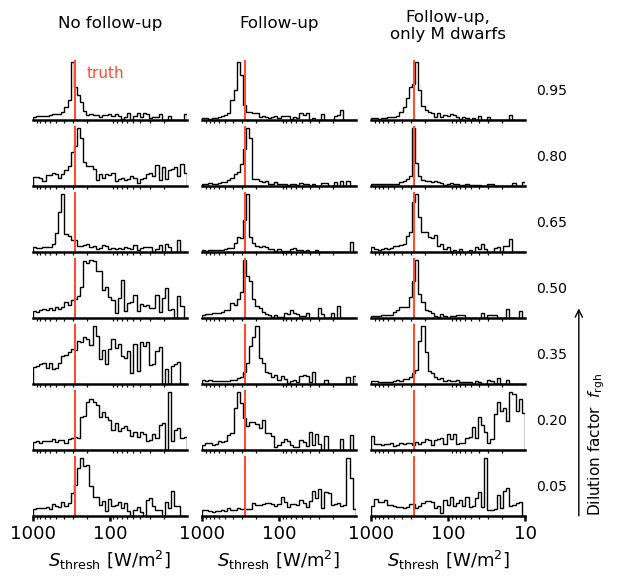

In [102]:
%%time
from plato_Sthresh_grid import plot_plato_Sthresh_grid

grids = [res_fg_plato100, res_fg_plato_rho, res_fg_plato_M_rho_100]
axs = plot_plato_Sthresh_grid(grids, planets_args)

In [440]:
# fig.savefig(paths.static / 'S_thresh_posteriors.pdf')

# Planet evolution schematics

(0.955, 1.265)

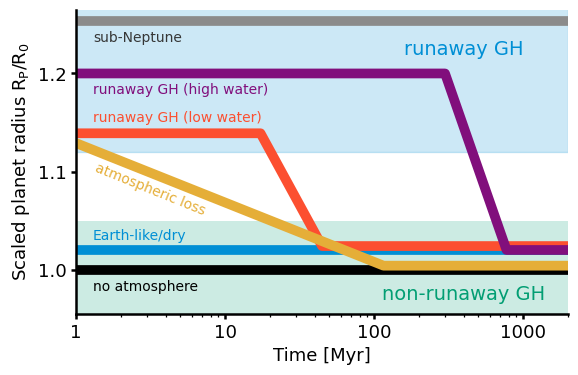

In [537]:
from scipy.interpolate import splrep, BSpline


def interpolate_grid(t, R):
    tck = splrep(t, R, k=3) 
    # t_fine = np.geomspace(min(t), max(t), 50)
    t_fine = np.linspace(min(t), max(t), 50)
    return 10**t_fine, BSpline(*tck)(t_fine)

def plot_planet_evo(N_time=9, v_offset=0.004, interpolate=False, **kwargs):
    fig, ax = plt.subplots()
    
    t = np.geomspace(1., 2000., N_time)
    R_noatm = [1. for t_ in t]
    R_hz = np.array([1.02,1.02,1.02, 1.02, 1.02, 1.02,1.02,1.02,1.02]) 
    R_rgh_lo = np.array([1.135, 1.135, 1.135, 1.135, 1.02, 1.02, 1.02, 1.02,1.02]) + v_offset
    R_rgh_hi = np.array([1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.2, 1.02,1.02]) 
    R_atmloss = np.array([1.125, 1.1, 1.075, 1.05, 1.025, 1.0, 1.0, 1.0, 1.0]) + v_offset
    R_subNeptune = np.array([1.25,1.25,1.25,1.25,1.25,1.25,1.25,1.25, 1.25]) + v_offset
    c = ['k', 'C2', 'C1', 'C4', 'C3', 'C7']

    for R, col in zip([R_noatm, R_hz, R_rgh_lo, R_rgh_hi, R_atmloss, R_subNeptune], 
                      c):
        # ax.plot(t, savgol_filter(R, window_length=7, polyorder=2, mode='nearest'), c=col, **kwargs)
        if interpolate:
            ax.plot(*interpolate_grid(np.log(t), R), c=col, **kwargs)
        else:
            ax.plot(t, R, c=col, **kwargs)
            
    ax.axhspan(.9, 1.05, alpha=.2)
    ax.text(400., .965, 'non-runaway GH', rotation=0, va='bottom', 
            ha='center', c='C0', alpha=1., fontsize=14)
    ax.axhspan(1.12, 1.27, alpha=.2, color='C2')
    ax.text(400., 1.215, 'runaway GH', rotation=0, va='bottom', 
            ha='center', c='C2', alpha=1., fontsize=14)
    
    def annotate(text, coords, color, **annotate_kwargs):
        ax.text(*coords, text, c=color, va='bottom', ha='left',
                fontsize=10, **annotate_kwargs)
        
    annotate('no atmosphere', (1.3, .975), 'k') 
    annotate('Earth-like/dry', (1.3, 1.027), 'C2') 
    annotate('atmospheric loss', (1.3,1.053), 'C3', rotation=-22) 
    annotate('runaway GH (low water)', (1.3,1.148), 'C1') 
    annotate('runaway GH (high water)', (1.3,1.176), 'C4') 
    annotate('sub-Neptune', (1.3,1.229), 'xkcd:dark grey') 
        
    ax.set_xscale('log')
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel('Time [Myr]')
    ax.set_ylabel('Scaled planet radius R$_\mathrm{P}$/R$_\mathrm{0}$')
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    ax.yaxis.set_ticks(np.arange(1., 1.4, 0.1))
    # ax.get_yaxis().set_major_formatter(FormatStrFormatter('%.2f'))


    return fig, ax

# with plt.xkcd(scale=1, length=75, randomness=1.5):
if True:
    fig, ax = plot_planet_evo(interpolate=False, lw=7.)

ax.set_xlim(1., 2000.)
ax.set_ylim(.955, 1.265)

In [538]:
# fig.savefig(paths.static / 'radiusevolution.pdf')

# Sanity checks
test robustness of procedure

## binned stats instead of running mean

In [538]:
results_binned = hypotest(data, parameter_of_interest, binned=True)  # this time, perform hypothesis tests on binned average R/rho

The evidence in favor of the hypothesis is: dlnZ = 27.7 (corresponds to p = 0.000)


Text(0.5, 1.13, 'Optimistic survey (binned)')

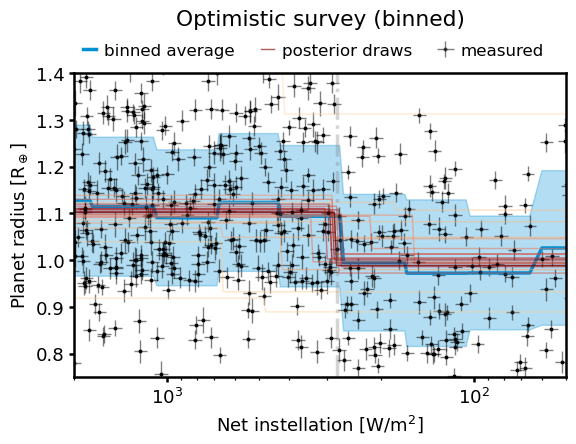

In [539]:
fig, ax = plot_survey(data, results_binned, parameter_of_interest, show_rolling_mean=False, show_binned_stats=True)
ax.set_title('Optimistic survey (binned)', y=1.13)

# ax.set_xlim(40, 2e3)
# ax.set_ylim(.7, 1.5)

In [540]:
# fig.savefig(paths.static / 'optimistic_R-S_binned.pdf')

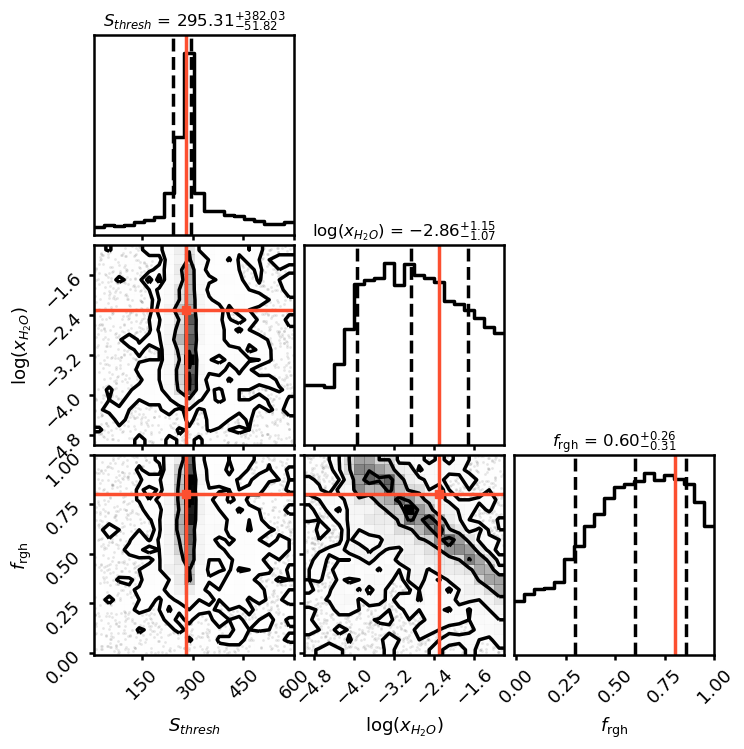

In [541]:
fig = cornerplot(results_binned, params, log, planets_args, parameter_of_interest)

## alternative M-R relation

In [322]:
%%time
from bioverse.hypothesis import compute_avg_deltaR_deltaRho

# N_runs = 50   # number of randomized runs for each hypothesis grid point

# choose a coarse grid in f_rgh (should include optimistic f_rgh = 0.8 case)
reduced_args = {key: planets_args[key] for key in planets_args if (key != 'f_rgh')} # remove keys used in the grid
f_grid = np.linspace(0., 1., 6)


for mr_relation in ['Wolfgang2016','earthlike']:
    planets_kwargs_MR = {'mr_relation' : mr_relation}
    stars_args_MR, planets_args_MR = get_generator_args()
    for key, value in planets_kwargs_MR.items():
            planets_args_MR[key] = value
    g_MR = generate_generator(**planets_args_MR)

    avg_deltaR_deltaRho_MR = compute_avg_deltaR_deltaRho(stars_args_MR, planets_args_MR, savefile=False)
    select_mechanisms = (avg_deltaR_deltaRho_MR.gh_increase == planets_args_MR['gh_increase']) & (
                        avg_deltaR_deltaRho_MR.water_incorp == planets_args_MR['water_incorp'])

if True:
    for R_rho, b, b_null, labels in zip(['R'], [bounds_R], [bounds_null], [labels]):
        f_dR_MR = scipy.interpolate.interp1d(avg_deltaR_deltaRho_MR[select_mechanisms].wrr,
                    avg_deltaR_deltaRho_MR[select_mechanisms]['delta_{}'.format(R_rho)],
                    fill_value='extrapolate') 
        h_magmaocean_MR = Hypothesis(magma_ocean_hypo, b, params=params, features=features, labels=labels, 
                                      log=log, parameter_of_interest=R_rho, f_dR=f_dR_MR)
        h_magmaocean_MR.h_null = Hypothesis(magma_ocean_f0, b_null, params=('{}_avg_random'.format(R_rho),), features=features, labels=labels, log=(log[-1],))

        res_fg_MR = analysis.test_hypothesis_grid(h_magmaocean_MR, g_MR, survey, f_rgh=f_grid,
                                            N=N_runs, processes=N_processes, return_chains=True,
                                            **reduced_args)
        pickle.dump(res_fg_MR, open(paperdatadir + 'bioverse_objects/optimistic_MR_{}.pkl'.format(mr_relation),'wb')) 

Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Generator
Created a new Ge

100%|██████████████████████████████████████████████████████████████████████████████| 300/300 [1:03:28<00:00, 12.70s/it]

CPU times: user 57min 7s, sys: 23.3 s, total: 57min 31s
Wall time: 2h 1min 7s


In [476]:
# ======================
hypothesisgrids = {'res_fg_MR_Wolfgang2016':'optimistic_MR_Wolfgang2016.pkl', 'res_fg_MR_earthlike':'optimistic_MR_earthlike.pkl',
                   'res_optimistic_H2O_fg':'optimistic_H2O-f-grid.pkl'}
for varname, path in zip(hypothesisgrids.keys(),
    [paperdatadir + 'bioverse_objects/' + fname for fname in hypothesisgrids.values()]):
    with open(path, 'rb') as f:
        loaded_obj = pickle.load(f)
        exec(varname + '= loaded_obj') 

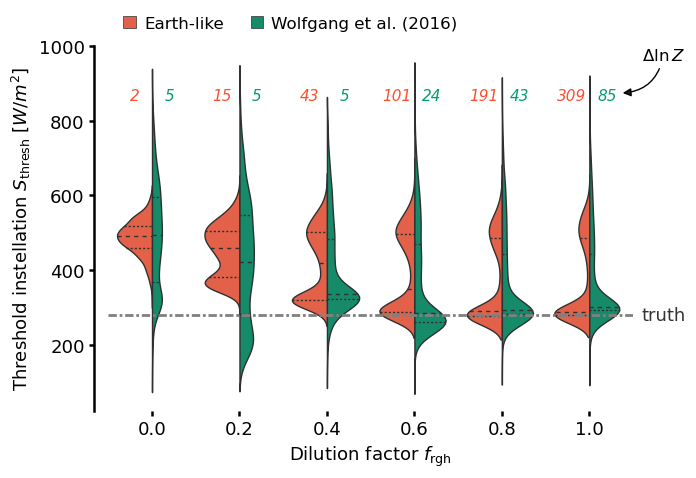

In [492]:
import seaborn as sns
from matplotlib.transforms import blended_transform_factory

def plot_splitviolin():
    # sns.set_theme(style="whitegrid")
    earthlike = pd.DataFrame(np.mean(res_fg_MR_earthlike['chains'][:,:,:,0].T, axis=1), columns=res_fg_MR_earthlike['grid']['f_rgh'])
    earthlike.loc[:,'M-R relation'] = 'Earth-like'
    wolfgang = pd.DataFrame(np.mean(res_fg_MR_Wolfgang2016['chains'][:,:,:,0].T, axis=1), columns=res_fg_MR_Wolfgang2016['grid']['f_rgh'])
    wolfgang = wolfgang[[c for c in wolfgang.columns if c in earthlike.columns]]
    
    wolfgang.loc[:,'M-R relation'] = 'Wolfgang et al. (2016)'
    mr_df = pd.merge(left=earthlike, right=wolfgang, how='outer')
    
    # workaround for a weird rounding error...
    colnames = [np.round(c, decimals=1) for c in mr_df.columns[:-1]]
    colnames.append('M-R relation')
    mr_df.columns = colnames
    
    mr = pd.melt(mr_df, id_vars=['M-R relation'], var_name='f_rgh', value_name='S_thresh')
    mr = mr[mr['S_thresh'].notna()]

    # Draw a nested violinplot and split the violins for easier comparison
    # fig, ax = plt.subplots(figsize=[12,4])
    ax = sns.violinplot(data=mr, x="f_rgh", y="S_thresh", hue="M-R relation", 
                   split=True, 
                   inner="quartile", 
                   # cut=0.5,
                   # saturation=.8,
                   linewidth=1.,
                   palette={'Earth-like':'C1', 'Wolfgang et al. (2016)':'C0'})
    
    # plot truths
    ax.text(5.6,planets_args['S_thresh'], 'truth', rotation=0, ha='left', c='.2',
            va='center', fontsize=13)
    ax.axhline(planets_args['S_thresh'], c='gray', lw=2., ls=(0, (3, 1, 1, 1)))
    
    # show dlnZ
    mean_dlnZ_earthlike = np.mean(res_fg_MR_earthlike['dlnZ'], axis=1)
    mean_dlnZ_wolfgang= np.mean(res_fg_MR_Wolfgang2016['dlnZ'], axis=1)
    trans = blended_transform_factory(x_transform=ax.transData, y_transform=ax.transAxes)
    for i, (dlnZ_e, dlnZ_w) in enumerate(zip(mean_dlnZ_earthlike, mean_dlnZ_wolfgang)):
        ax.text(i - 0.2, .85, '{:.0f}'.format(dlnZ_e), rotation=0, c='C1',
        transform=trans, fontsize=11, ha='center', style='italic') 
        ax.text(i + 0.2, .85, '{:.0f}'.format(dlnZ_w), rotation=0, c='C0',
        transform=trans, fontsize=11, ha='center', style='italic') 
    ax.annotate('$\Delta \ln Z$', (5.35, .87), (5.6, .96), xycoords=trans, fontsize=12,
                arrowprops=dict(arrowstyle="-|>", fc='k', connectionstyle="arc3,rad=-0.4"))
    
    sns.despine(left=False, bottom=True, offset=10.)
    ax.set_xlabel('Dilution factor $f_\\mathrm{rgh}$')
    ax.set_ylabel('Threshold instellation $S_\\mathrm{thresh} \, \, [W/m^2]$')
    ax.legend(fontsize=12, loc='lower left', ncol=2, bbox_to_anchor=(0., 1.),
                                  frameon=False, columnspacing=1.6)
    return ax

ax = plot_splitviolin()


In [493]:
# ax.get_figure().savefig(paths.static / 'MR-violins.pdf')

# Table with assumptions, parameters


In [659]:
# create table
def log_or_not(is_log):
    return 'log-uniform' if is_log else 'uniform'

# def fmt_prior(prior):
    # return '[]'

params_hdr = ['Parameter', 'Value', 'Unit', 'Description']
params_dict = {'\\textbf{Stellar sample}': [None, None, None],
               '$G_\mathrm{max}$':[stars_args['M_G_max'], None, 'Maximum Gaia magnitude'], 
               '$M_\mathrm{\star, max}$':[stars_args['M_st_max'], '$M_\odot$', 'Maximum stellar mass'],
               'Luminosity evolution':[None, None, '\citet{Baraffe1998}'],
               '~\\\ \\textbf{Planetary parameters}': [None, None, None],
               '$M_\mathrm{P}$':['{} -- {}'.format(planets_args['M_min'], planets_args['M_max']), 'M$_\oplus$', 'Planetary mass range'],
               '$R_\mathrm{P, min}$':[planets_args['R_min'], '$R_\oplus$', 'Minimum planet radius'],
               'Baseline mass-radius relation':[None, None, '\citet{Zeng2016} \SI{100}{\percent} $\mathrm{MgSiO_3}$\\tablenotemark{a}'],
               '$\delta_\mathrm{min}$':[int(planets_args['depth_min']*1e6), 'ppm', 'Minimum transit depth'],
               '$P_\mathrm{max}$':[int(planets_args['P_max']), 'd', 'Maximum orbital period [d]'],
               '$S$':['{:.0f} -- {:.0f}'.format(planets_args['S_min'], planets_args['S_max']), '\SI{}{\watt\per\meter\squared}', 'Net instellation range'],
               '$S_\mathrm{thresh}$':[int(planets_args['S_thresh']), '\SI{}{\watt\per\meter\squared}', 'Threshold instellation for runaway greenhouse'],
               '~\\\ \\textbf{Runaway greenhouse model}': [None, None, None],
               'Runaway greenhouse atmospheric models':[None, None, '\citet{Turbet2020,Dorn2021}'],
               '$x_{H_2O}$':['\SIrange{e-5}{0.1}{}', None, 'Water mass fraction (fiducial case: {})'.format(planets_args['wrr'])],
               '$f_\mathrm{rgh}$':['\SIrange{0}{1}{}', None, 'Dilution factor (fiducial case: {})'.format(planets_args['f_rgh'])],
               '~\\\ \\textbf{Priors}': [None, None, None],
               '$\Pi(S_\mathrm{thresh}$)':['[{}, {}]'.format(*[int(f) for f in bounds_R[0]]), '\SI{}{\watt\per\meter\squared}', log_or_not(log[0])],
               '$\Pi(x_{H_2O})$':['[\SI{e-5}{}, \SI{0.1}{}]', None, log_or_not(log[1])],
               '$\Pi(f_\mathrm{rgh})$':['[{}, {}]'.format(*[int(f) for f in bounds_R[2]]), None, log_or_not(log[2])],
               '$\Pi(\\langle R_\mathrm{P}\\rangle_\mathrm{out})$':['[{}, {}]'.format(*[int(f) for f in bounds_R[3]]), '$R_\oplus$', 'Mean radius of non-runaway planets, ' +log_or_not(log[3])]
}
params_table = pd.DataFrame.from_dict(params_dict, orient='index', columns=params_hdr[1:])
params_table.index.name = params_hdr[0]
tablenotes = '\\tablenotetext{a}{For a comparison with alternative interior compositions, see Appendix~\\ref{app:MR_relation}.}'
params_table

,Value,Unit,Description
Parameter,,,
\textbf{Stellar sample},None,None,None
$G_\mathrm{max}$,16,None,Maximum Gaia magnitude
"$M_\mathrm{\star, max}$",1.5,$M_\odot$,Maximum stellar mass
Luminosity evolution,None,None,\citet{Baraffe1998}
~\\ \textbf{Planetary parameters},None,None,None
$M_\mathrm{P}$,0.1 -- 2.0,M$_\oplus$,Planetary mass range
"$R_\mathrm{P, min}$",0.75,$R_\oplus$,Minimum planet radius
Baseline mass-radius relation,None,None,\citet{Zeng2016} \SI{100}{\percent} $\mathrm{M...
$\delta_\mathrm{min}$,80,ppm,Minimum transit depth


In [660]:
# write table to Latex
from astropy.io import ascii
from astropy.table import Table

tab = Table.from_pandas(params_table, index=True)
ascii.write(tab, output=papertexdir+'table_parameters.tex', format='aastex', caption='Key assumptions and model parameters used in our simulation setup',
            overwrite=True, latexdict={'tablefoot':tablenotes +'\n' +'\label{tab:params_table}', 'tabletype': 'deluxetable*', 'col_align':'lrll'})